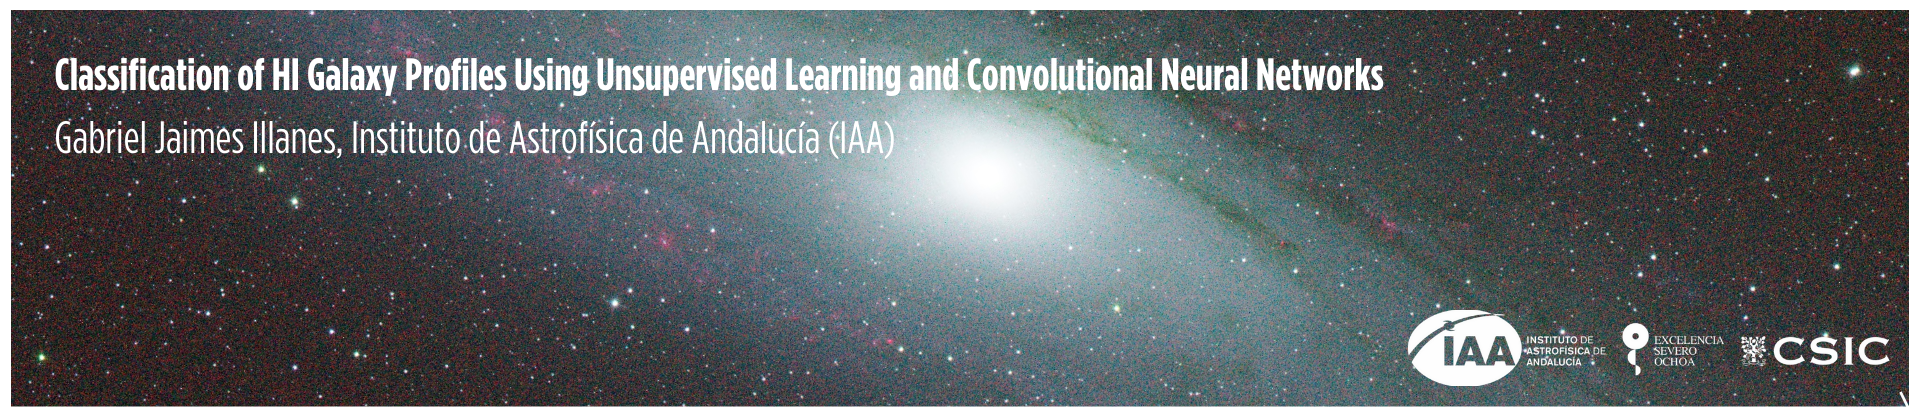

---

<div style="text-align: center;">
    <h2>HI PROFILES CLASSIFICATION USING SHAPELETS AND CNN</h2>
</div>



---

### Step 1: KNN Classification - Shapelets | ALFALFA

This code performs classification and clustering of astronomical data from FITS files using various machine learning techniques. It begins by importing necessary libraries, loading the FITS data, and filtering the files based on AGC IDs from an Excel file. After pre-filtering, it shuffles and splits the data for training and testing. The data is normalized, and different clustering methods such as K-Means, DBSCAN, or Spectral Clustering are applied to group the data. A Shapelets model is then trained for classification using a K-Nearest Neighbors (KNN) algorithm. The results are evaluated with confusion matrices and classification reports, and the final results, including visualizations, are saved in a PDF file.

In [ ]:
!pip install numpy pandas astropy scikit-learn tslearn matplotlib openpyxl


Current Directory: D:\1. JAE Intro ICU\sp_im\sp_im_double_lorentzian
Total AGC IDs to filter by: 24742
First 20 AGC IDs to filter by:
['A105367', 'A333313', 'A331060', 'A331061', 'A104570', 'A331405', 'A102896', 'A630358', 'A105368', 'A331066', 'A102571', 'A102728', 'A331067', 'A104678', 'A105370', 'A012893', 'A012896', 'A102729', 'A331070', 'A012895']
Total FITS files found before filtering: 1000
Total FITS files after filtering: 844
Total FITS files after limiting to 35000: 844
A000001_double_lorentzian.fits
A000003_double_lorentzian.fits
A000004_double_lorentzian.fits
A000007_double_lorentzian.fits
A000010_double_lorentzian.fits
A000011_double_lorentzian.fits
A000012_double_lorentzian.fits
A000014_double_lorentzian.fits
A000015_double_lorentzian.fits
A000017_double_lorentzian.fits
Selected method for Classification: spectral_clustering
Total number of samples: 844
Number of samples for group generation (0.25): 211
Number of samples for classification (0.75): 633


C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Se encontraron archivos sin clasificación:
          AGC      Name     RAJ2000    DEJ2000         RAO        DEO   Vhel  \
0      105367       NaN  00 00 00.4  +05 26 36  00 00 00.8  +05 26 33  11983   
1      333313       NaN  00 00 00.9  +24 54 32  23 59 59.4  +24 54 27  11181   
2      331060  478-009b  00 00 02.5  +23 05 05  00 00 03.4  +23 05 15   4463   
3      331061   456-013  00 00 02.5  +15 52 20  00 00 02.1  +15 52 54   6007   
4      104570       NaN  00 00 01.6  +32 42 30  00 00 01.2  +32 42 37  10614   
...       ...       ...         ...        ...         ...        ...    ...   
24737  331054   517-008  23 59 40.9  +34 20 50  23 59 42.9  +34 20 43   4900   
24738  331052   Eder Dw  23 59 44.4  +27 15 28  23 59 45.0  +27 15 14   4692   
24739  334869       NaN  23 59 50.8  +21 33 01  23 59 50.5  +21 33 22  10432   
24740  332965       NaN  23 59 55.6  +05 14 20  23 59 54.9  +05 14 20   3038   
24741  332118       NaN  23 59 57.3  +04 53 50  23 59 57.8  +04 54 04   9207 

C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


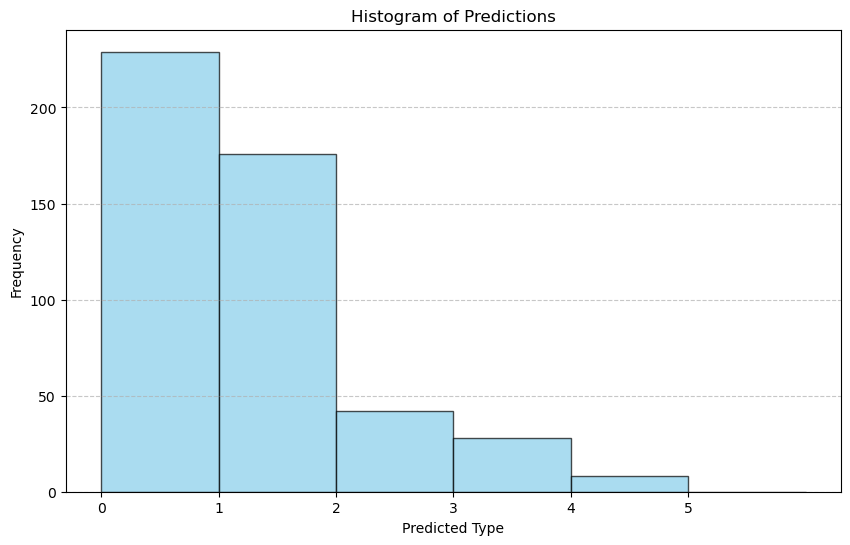

Plots and text saved in filtered_data_alfalfa_POLY_classification_results_shapelets_spectral_clustering_double_lorentzian.pdf


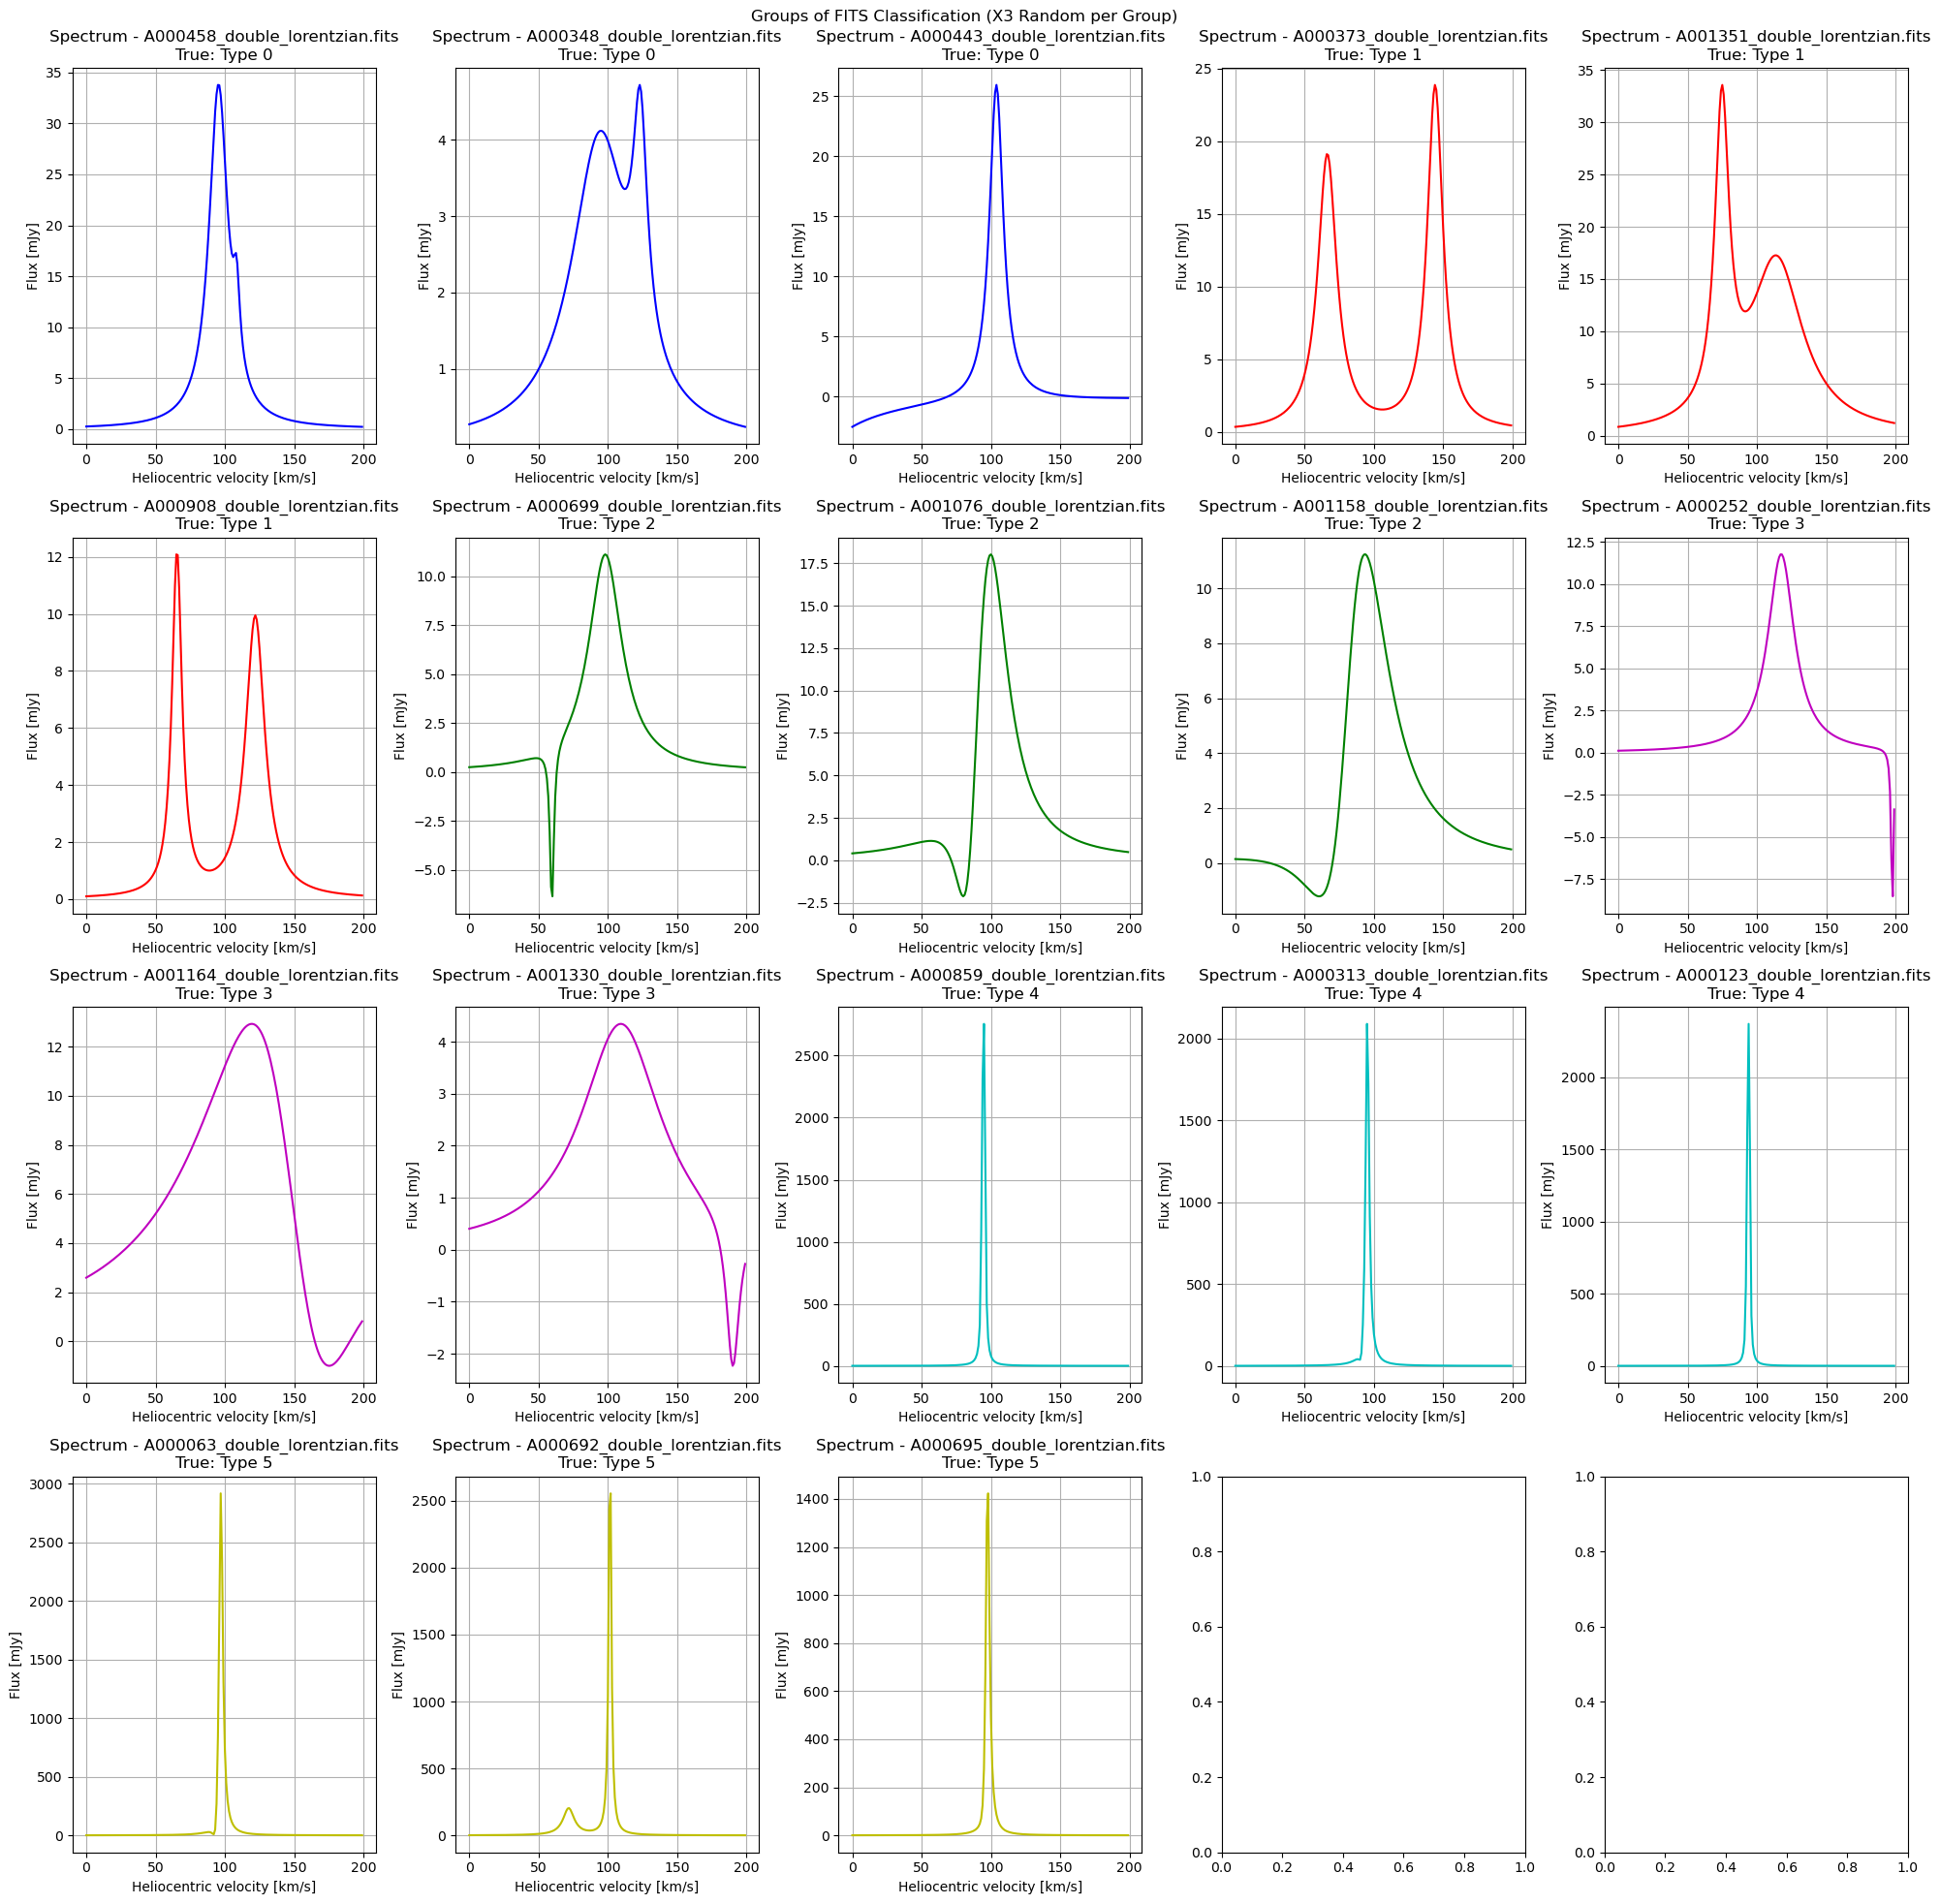

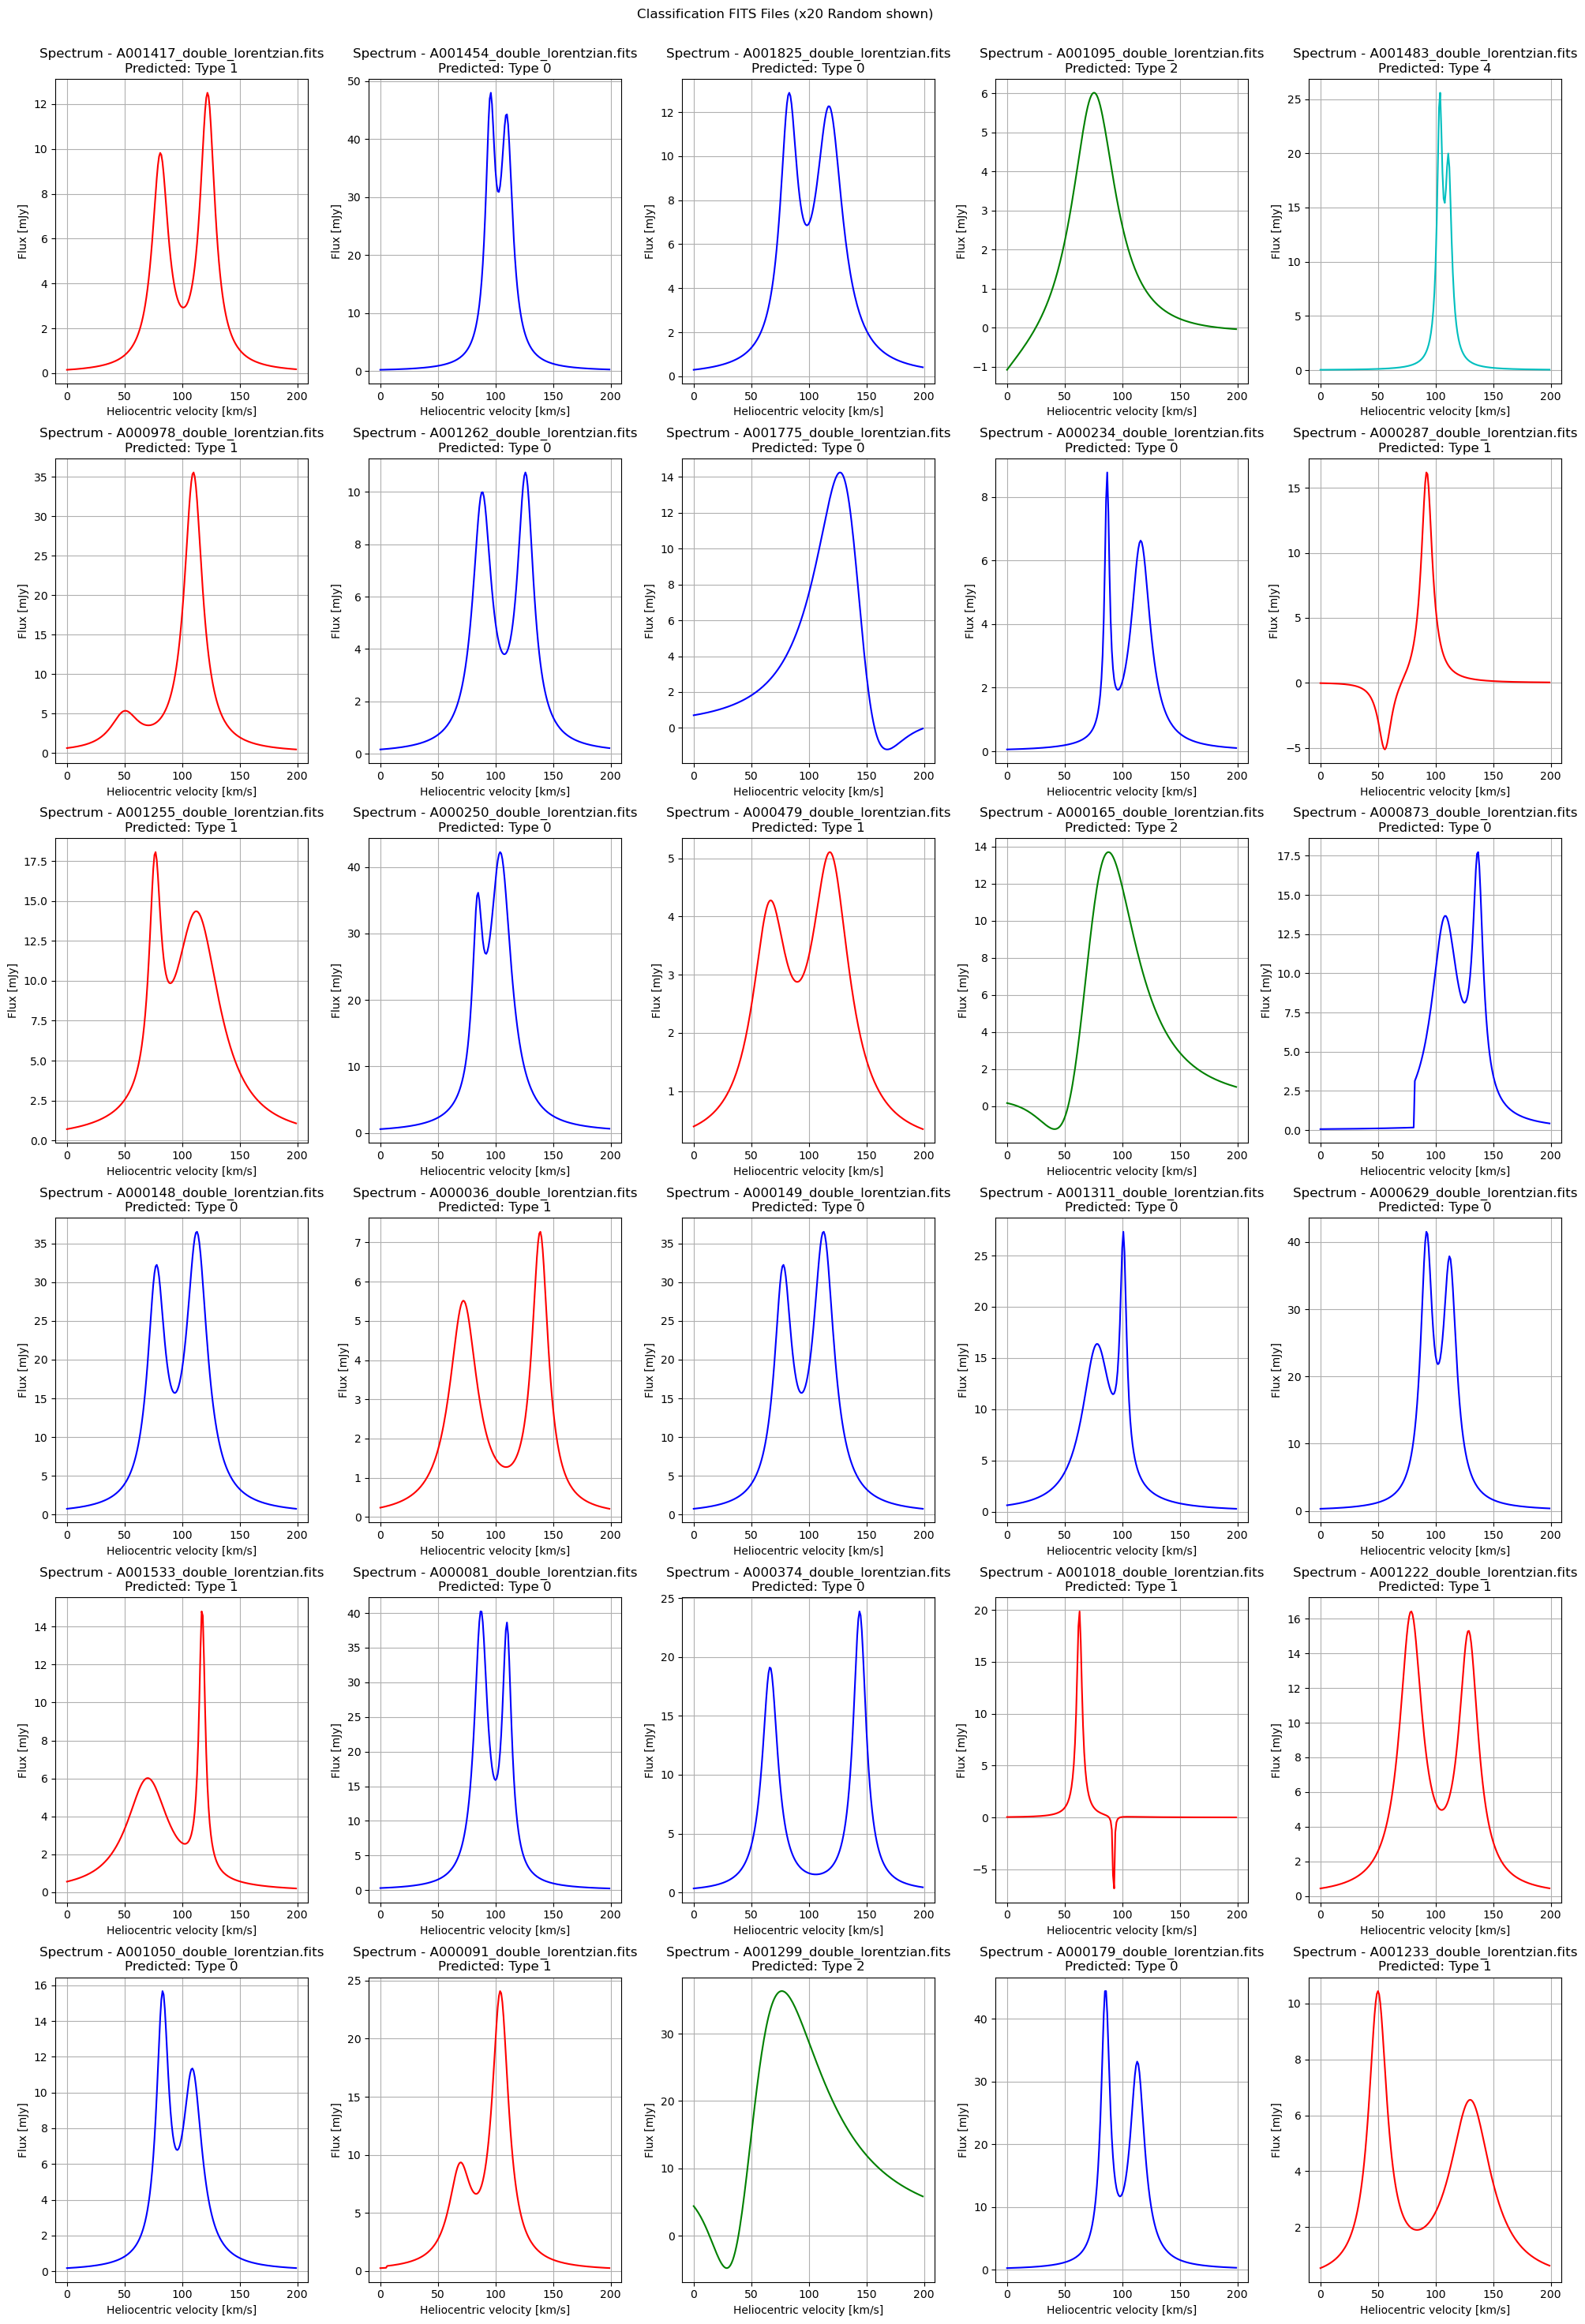

In [3]:
import numpy as np
import pandas as pd
from astropy.io import fits
from tslearn.shapelets import LearningShapelets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, AffinityPropagation, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import glob
import os
import random

# Training variables
clustering_method = "spectral_clustering"  # Specify clustering method: "k_means", "spectral_clustering", "DBSCAN", "AgglomerativeClustering", "MeanShift", "AffinityPropagation", "GaussianMixture"
type_of_classification = "double_lorentzian"   #1 , 2 , 3 o double_lorentzian
number_max_fits = 35000
percentage_training = 0.25
ngroups = 6

# Change to the FITS data directory
#fits_data_directory = 'D:/1. JAE Intro ICU/sp_im_busyfit/'
fits_data_directory = 'D:/1. JAE Intro ICU/sp_im/sp_im_double_lorentzian/'
os.chdir(fits_data_directory)
print("Current Directory:", os.getcwd())

# Function to load data from FITS files
def load_fits_data(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[0].data[0]  # Get data from the first HDU
    return data

# Pre-filter based on 'AGC' column in the .xlsx file
alfalfa_df = pd.read_excel("filtered_data_alfalfa_1.xlsx")
agc_ids = alfalfa_df['AGC'].astype(str).tolist()
formatted_agc_ids = [f"A{agc_id.zfill(6)}" for agc_id in agc_ids]

print(f"Total AGC IDs to filter by: {len(formatted_agc_ids)}")
print("First 20 AGC IDs to filter by:")
print(formatted_agc_ids[:20])

# List and filter FITS files based on AGC IDs
#file_paths_total = glob.glob(f'*.fits_busyfit_{type_of_classification}.fits')
file_paths_total = glob.glob(f'*_{type_of_classification}.fits')
print(f"Total FITS files found before filtering: {len(file_paths_total)}")

filtered_file_paths = [fp for fp in file_paths_total if any(agc_id in fp for agc_id in formatted_agc_ids)]
print(f"Total FITS files after filtering: {len(filtered_file_paths)}")

# Limit the number of files to process (if needed)
filtered_file_paths = filtered_file_paths[:number_max_fits]
print(f"Total FITS files after limiting to {number_max_fits}: {len(filtered_file_paths)}")

# Verify some of the filtered FITS files
for fp in filtered_file_paths[:10]:
    print(fp)

# Randomly shuffle and split the filtered FITS files into training and classification sets
random.shuffle(filtered_file_paths)
training_size = round(len(filtered_file_paths) * percentage_training)
file_paths_for_groups = filtered_file_paths[:training_size]
file_paths = filtered_file_paths[training_size:]

print("Selected method for Classification:", clustering_method)
print("Total number of samples:", len(filtered_file_paths))
print(f"Number of samples for group generation ({percentage_training}):", len(file_paths_for_groups))
print(f"Number of samples for classification ({1 - percentage_training}):", len(file_paths))

# Number of files per group (1/4 of FITS)
lgroups = round(len(file_paths) * percentage_training / ngroups)

# Ensure there are enough files for the defined groups
assert ngroups * lgroups <= len(file_paths), "Not enough files for the defined groups"

# Processing additional steps as needed...

#-------- 2. Data Preprocessing ----------
def preprocess_data(file_paths):
    X_all = []
    max_length = 0
    for file in file_paths:
        data = load_fits_data(file)
        if data is not None and len(data) > 0:
            X_all.append(data)
            if len(data) > max_length:
                max_length = len(data)
    # Pad or truncate sequences
    X_all = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_all]
    return X_all, max_length

X_all, max_length = preprocess_data(file_paths)

# Normalization
scaler = TimeSeriesScalerMinMax()
X_all_scaled = scaler.fit_transform(np.array(X_all, dtype=np.float64))

# Ensure X_all_scaled is two-dimensional
X_all_scaled = X_all_scaled.reshape(X_all_scaled.shape[0], -1)

# Apply selected clustering method
if clustering_method == "k_means":
    # Apply K-means clustering to group spectra with similar characteristics
    clustering_model = KMeans(n_clusters=ngroups, random_state=0)
elif clustering_method == "spectral_clustering":
    # Apply Spectral Clustering
    try:
        clustering_model = SpectralClustering(n_clusters=ngroups, random_state=0, affinity='nearest_neighbors', n_neighbors=10)
    except ValueError as e:
        print(f"Error applying SpectralClustering: {e}")
        clustering_model = None
elif clustering_method == "DBSCAN":
    # Apply DBSCAN
    clustering_model = DBSCAN(eps=0.5, min_samples=5)
elif clustering_method == "AgglomerativeClustering":
    # Apply Agglomerative Clustering
    clustering_model = AgglomerativeClustering(n_clusters=ngroups)
elif clustering_method == "MeanShift":
    # Apply Mean Shift
    clustering_model = MeanShift()
elif clustering_method == "AffinityPropagation":
    # Apply Affinity Propagation
    clustering_model = AffinityPropagation()
elif clustering_method == "GaussianMixture":
    # Apply Gaussian Mixture Model
    clustering_model = GaussianMixture(n_components=ngroups)
else:
    raise ValueError("Unsupported clustering method specified.")

if clustering_method in ["MeanShift", "AffinityPropagation", "GaussianMixture"]:
    # Fit the model and predict
    clustering_model.fit(X_all_scaled)
    if clustering_method == "GaussianMixture":
        y_all = clustering_model.predict(X_all_scaled)
    else:
        y_all = clustering_model.predict(X_all_scaled)
else:
    # Fit the model and predict
    y_all = clustering_model.fit_predict(X_all_scaled)

# Check if clustering was successful
if len(set(y_all)) < ngroups:
    raise ValueError("El método de clustering no generó suficientes grupos.")

# Select the first `ngroups * lgroups` files for training
X_train = []
y_train = []
for group in range(ngroups):
    indices = np.where(y_all == group)[0][:lgroups]
    if len(indices) > 0:
        X_train.extend([X_all[idx] for idx in indices])
        y_train.extend([group] * len(indices))
    else:
        print(f"Grupo {group} está vacío y no se incluirá en el entrenamiento.")

# Use the remaining files for testing
X_test = [X_all[idx] for idx in range(len(X_all)) if idx not in np.concatenate([np.where(y_all == group)[0][:lgroups] for group in range(ngroups)])]

# Ensure all sequences have the same length
X_train = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_train]
X_test = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_test]

# Verify if X_train and y_train are not empty
if not X_train or not y_train:
    raise ValueError("X_train or y_train are empty. Check input data.")

# Ensure X_train is a 2D array
X_train = np.array(X_train, dtype=np.float64)
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)

# Verify the length of y_train
if len(y_train) != len(X_train):
    raise ValueError("The length of y_train does not match the length of X_train.")

# Convert y_train to a numpy array if it is not already
y_train = np.array(y_train)

# Define colors for each group
colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k', 'orange']  # Extend this list if you have more than 8 groups

#-------- 3. Model Training ----------
# Train shapelets model
model = LearningShapelets(n_shapelets_per_size={100: 10, 50: 8, 30: 5, 10: 3}, max_iter=350, batch_size=10, scale=True)
model.fit(X_train, y_train)


#-------- 4. FITS Files Visualization ----------
def plot_fits_spectra(file_paths, title, labels=None, predictions=None, num_columns=5):
    num_files = len(file_paths)
    num_rows = (num_files + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    for i, file_path in enumerate(file_paths):
        with fits.open(file_path) as fits_file:
            spectrum_data = fits_file[0].data
            spectrum_data = np.squeeze(spectrum_data)
        wavelength = np.arange(len(spectrum_data))
        ax = axes[i // num_columns, i % num_columns]
        if predictions is not None:
            color = colors[predictions[i]]
            label = f'Predicted: Type {predictions[i]}'
        elif labels is not None:
            color = colors[labels[i]]
            label = f'True: Type {labels[i]}'
        else:
            color = 'b'
            label = ''
        ax.plot(wavelength, spectrum_data, color=color)
        ax.set_xlabel('Heliocentric velocity [km/s]')
        ax.set_ylabel('Flux [mJy]')
        ax.set_title(f'Spectrum - {file_path}\n{label}')
        ax.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig
def plot_fits_spectra_random(file_paths, title, labels=None, predictions=None, num_columns=5, num_plots=30):
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    random_indices = np.random.choice(len(file_paths), num_plots, replace=False)
    for i, idx in enumerate(random_indices):
        file_path = file_paths[idx]
        with fits.open(file_path) as hdul:
            data_spectrum = hdul[0].data
            data_spectrum = np.squeeze(data_spectrum)
        velocity = np.arange(len(data_spectrum))
        ax = axes[i // num_columns, i % num_columns]
        if predictions is not None:
            color = colors[predictions[idx]]
            label = f'Predicted: Type {predictions[idx]}'
        elif labels is not None:
            color = colors[labels[idx]]
            label = f'True: Type {labels[idx]}'
        else:
            color = 'b'
            label = ''
        ax.plot(velocity, data_spectrum, color=color)
        ax.set_xlabel('Heliocentric velocity [km/s]')
        ax.set_ylabel('Flux [mJy]')
        ax.set_title(f'Spectrum - {file_path}\n{label}')
        ax.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

def plot_random_samples_per_group(file_paths, y_all, y_train, ngroups, num_samples=3):
    selected_files = []
    selected_labels = []
    
    for group in range(ngroups):
        group_indices = np.where(y_all == group)[0]
        actual_num_samples = min(num_samples, len(group_indices))
        
        if actual_num_samples > 0:
            selected_indices = np.random.choice(group_indices, actual_num_samples, replace=False)
            selected_files.extend([file_paths[idx] for idx in selected_indices])
            selected_labels.extend([group] * actual_num_samples)
        else:
            print(f"Warning: Group {group} does not have enough elements to select {num_samples} samples.")
    
    return plot_fits_spectra(selected_files, title="Groups of FITS Classification (X3 Random per Group)", labels=selected_labels)


#-------- 5. Model Evaluation ----------
X_test_scaled = scaler.transform(np.array(X_test, dtype=np.float64))
X_test_transformed = model.transform(X_test_scaled)

# Classification using KNN
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(model.transform(X_train), y_train)
y_pred = knn.predict(X_test_transformed)

# Visualize test data with predictions
test_file_paths = [file_paths[idx] for idx in range(len(file_paths)) if idx not in np.concatenate([np.where(y_all == group)[0][:lgroups] for group in range(ngroups)])]
#plot_fits_spectra_random(test_file_paths, title="Classification FITS Files (x20 Random shown)", predictions=y_pred, num_columns=5, num_plots=30)

#-------- 6. Classification Results ----------

# Create a dictionary to map files to their classifications
file_to_classification = {file: prediction for file, prediction in zip(test_file_paths, y_pred)}

# Initialize the 'Classification' column with None
alfalfa_df['Classification'] = None

# Assign classifications to the corresponding AGC IDs in the DataFrame
for idx, row in alfalfa_df.iterrows():
    agc_id = str(row['AGC'])
    # Find the FITS file containing the AGC ID
    matched_file = next((file for file in file_paths_total if agc_id in file), None)
    if matched_file and matched_file in file_to_classification:
        alfalfa_df.at[idx, 'Classification'] = file_to_classification[matched_file]

# Check for any missing classifications
missing_classifications = alfalfa_df[alfalfa_df['Classification'].isna()]
if not missing_classifications.empty:
    print("Files with missing classifications found:")
    print(missing_classifications)

# Save the updated DataFrame to an Excel file
result_file_path = f"filtered_data_alfalfa_POLY_classification_results_shapelets_{clustering_method}_{type_of_classification}.xlsx"
alfalfa_df.to_excel(result_file_path, index=False)

print(f"\nClassifications saved to: {result_file_path}")

# Print the confusion matrix and classification report
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, model.predict(X_train)))
print("\nClassification Report:")
print(classification_report(y_train, model.predict(X_train)))

# Visualize the histogram of predictions
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=range(ngroups + 1), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Predictions')
plt.xlabel('Predicted Type')
plt.ylabel('Frequency')
plt.xticks(range(ngroups))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plot_random_samples_per_group(file_paths, y_all, y_train, ngroups)
plot_fits_spectra_random(test_file_paths, title="Classification FITS Files (x20 Random shown)", predictions=y_pred, num_columns=5, num_plots=30)

#-------- 7. Save as PDF Document ----------
from matplotlib.backends.backend_pdf import PdfPages
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from io import BytesIO
from PyPDF2 import PdfReader, PdfWriter  # Ensure you have PyPDF2 installed

# Create a PDF file
output_pdf_path = f"filtered_data_alfalfa_POLY_classification_results_shapelets_{clustering_method}_{type_of_classification}.pdf"

# Create a buffer for the text
packet = BytesIO()
can = canvas.Canvas(packet, pagesize=letter)

# Add text to the PDF
can.drawString(72, 720, f"Current Directory: {fits_data_directory}")
can.drawString(72, 705, f"Total AGC IDs to filter by: {len(formatted_agc_ids)}")
can.drawString(72, 690, "First 20 AGC IDs to filter by:")
for i, agc_id in enumerate(formatted_agc_ids[:20]):
    can.drawString(72, 675 - i*15, agc_id)

can.drawString(72, 360, f"Total FITS files found before filtering: {len(file_paths_total)}")
can.drawString(72, 345, f"Total FITS files after filtering: {len(filtered_file_paths)}")
can.drawString(72, 330, f"Total FITS files after limiting to {number_max_fits}: {len(filtered_file_paths)}")

random.shuffle(filtered_file_paths)
training_size = round(len(filtered_file_paths) * percentage_training)
file_paths_for_groups = filtered_file_paths[:training_size]
file_paths = filtered_file_paths[training_size:]

can.drawString(72, 315, f"Selected method for Classification: {clustering_method}")
can.drawString(72, 300, f"Total number of samples: {len(filtered_file_paths)}")
can.drawString(72, 285, f"Number of samples for group generation ({percentage_training}): {len(file_paths_for_groups)}")
can.drawString(72, 270, f"Number of samples for classification ({1 - percentage_training}): {len(file_paths)}")

lgroups = round(len(file_paths) * percentage_training / ngroups)
can.drawString(72, 255, f"Number of files per group: {lgroups}")

# Add additional text
can.drawString(72, 240, f"Train shapelets model:")
can.drawString(72, 225, f"model = LearningShapelets(n_shapelets_per_size={{100: 10, 50: 8, 30: 5, 10: 3}}, max_iter=350, batch_size=10, scale=True)")
can.drawString(72, 210, f"model.fit(X_train, y_train)")

can.drawString(72, 195, f"Classification using KNN:")
can.drawString(72, 180, f"knn = KNeighborsClassifier(n_neighbors=1)")
can.drawString(72, 165, f"knn.fit(model.transform(X_train), y_train)")
can.drawString(72, 150, f"y_pred = knn.predict(X_test_transformed)")

can.save()
packet.seek(0)

# Read the content of the created text page
new_pdf = PdfReader(packet)
first_page = new_pdf.pages[0]

# Generate all the plots

# Create and save plots in the final PDF file
with PdfWriter(output_pdf_path) as pdf_writer:
    # Add the text page
    pdf_writer.add_page(first_page)
    
    # Create a buffer to save plots
    plot_buffer = BytesIO()
    with PdfPages(plot_buffer) as pdf:
        # Save generated plots

        fig1 = plot_random_samples_per_group(file_paths, y_all, y_train, ngroups)
        pdf.savefig(fig1)
        plt.close(fig1)  # Close the plot to free memory
        
        fig2 = plot_fits_spectra_random(test_file_paths, title="Classification FITS Files (x20 Random shown)", predictions=y_pred, num_columns=5, num_plots=30)
        pdf.savefig(fig2)
        plt.close(fig2)  # Close the plot to free memory

        # Save the histogram of predictions
        fig3 = plt.figure(figsize=(10, 6))
        plt.hist(y_pred, bins=range(ngroups + 1), color='skyblue', edgecolor='black', alpha=0.7)
        plt.title('Histogram of Predictions')
        plt.xlabel('Predicted Type')
        plt.ylabel('Frequency')
        plt.xticks(range(ngroups))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        pdf.savefig(fig3)
        plt.close(fig3)  # Close the histogram to free memory

    # Read the content of the plot buffer and add to the final PDF
    plot_buffer.seek(0)
    plot_pdf = PdfReader(plot_buffer)
    for page in plot_pdf.pages:
        pdf_writer.add_page(page)

# Print a message indicating that the PDF file has been saved
print(f'Plots and text saved in {output_pdf_path}')




---

### Step 2: SVM Classification - Shapelets | ALFALFA

This code performs classification of high-dimensional data using Support Vector Machines (SVM). It begins by importing necessary libraries and loading the dataset, followed by pre-processing steps such as handling missing values and scaling the features. The data is then shuffled and split into training and testing sets. The SVM model is trained with a radial basis function (RBF) kernel to capture non-linear patterns in the data. After training, the model's performance is evaluated using confusion matrices and classification reports, measuring accuracy, precision, and recall. Finally, visualizations such as decision boundaries and support vectors are generated to illustrate the model's behavior, with the results saved to a PDF file for further analysis.

Current Directory: D:\1. JAE Intro ICU\sp_im_busyfit
Total AGC IDs to filter by: 24742
First 20 AGC IDs to filter by:
['A105367', 'A333313', 'A331060', 'A331061', 'A104570', 'A331405', 'A102896', 'A630358', 'A105368', 'A331066', 'A102571', 'A102728', 'A331067', 'A104678', 'A105370', 'A012893', 'A012896', 'A102729', 'A331070', 'A012895']
Total FITS files found before filtering: 30750
Total FITS files after filtering: 24063
Total FITS files after limiting to 35000: 24063
A000001.fits_busyfit_2.fits
A000003.fits_busyfit_2.fits
A000004.fits_busyfit_2.fits
A000007.fits_busyfit_2.fits
A000010.fits_busyfit_2.fits
A000011.fits_busyfit_2.fits
A000012.fits_busyfit_2.fits
A000014.fits_busyfit_2.fits
A000015.fits_busyfit_2.fits
A000017.fits_busyfit_2.fits
Selected method for Classification: AgglomerativeClustering
Total number of samples: 24063
Number of samples for group generation (0.25): 6016
Number of samples for classification (0.75): 18047
Se encontraron archivos sin clasificación:
         

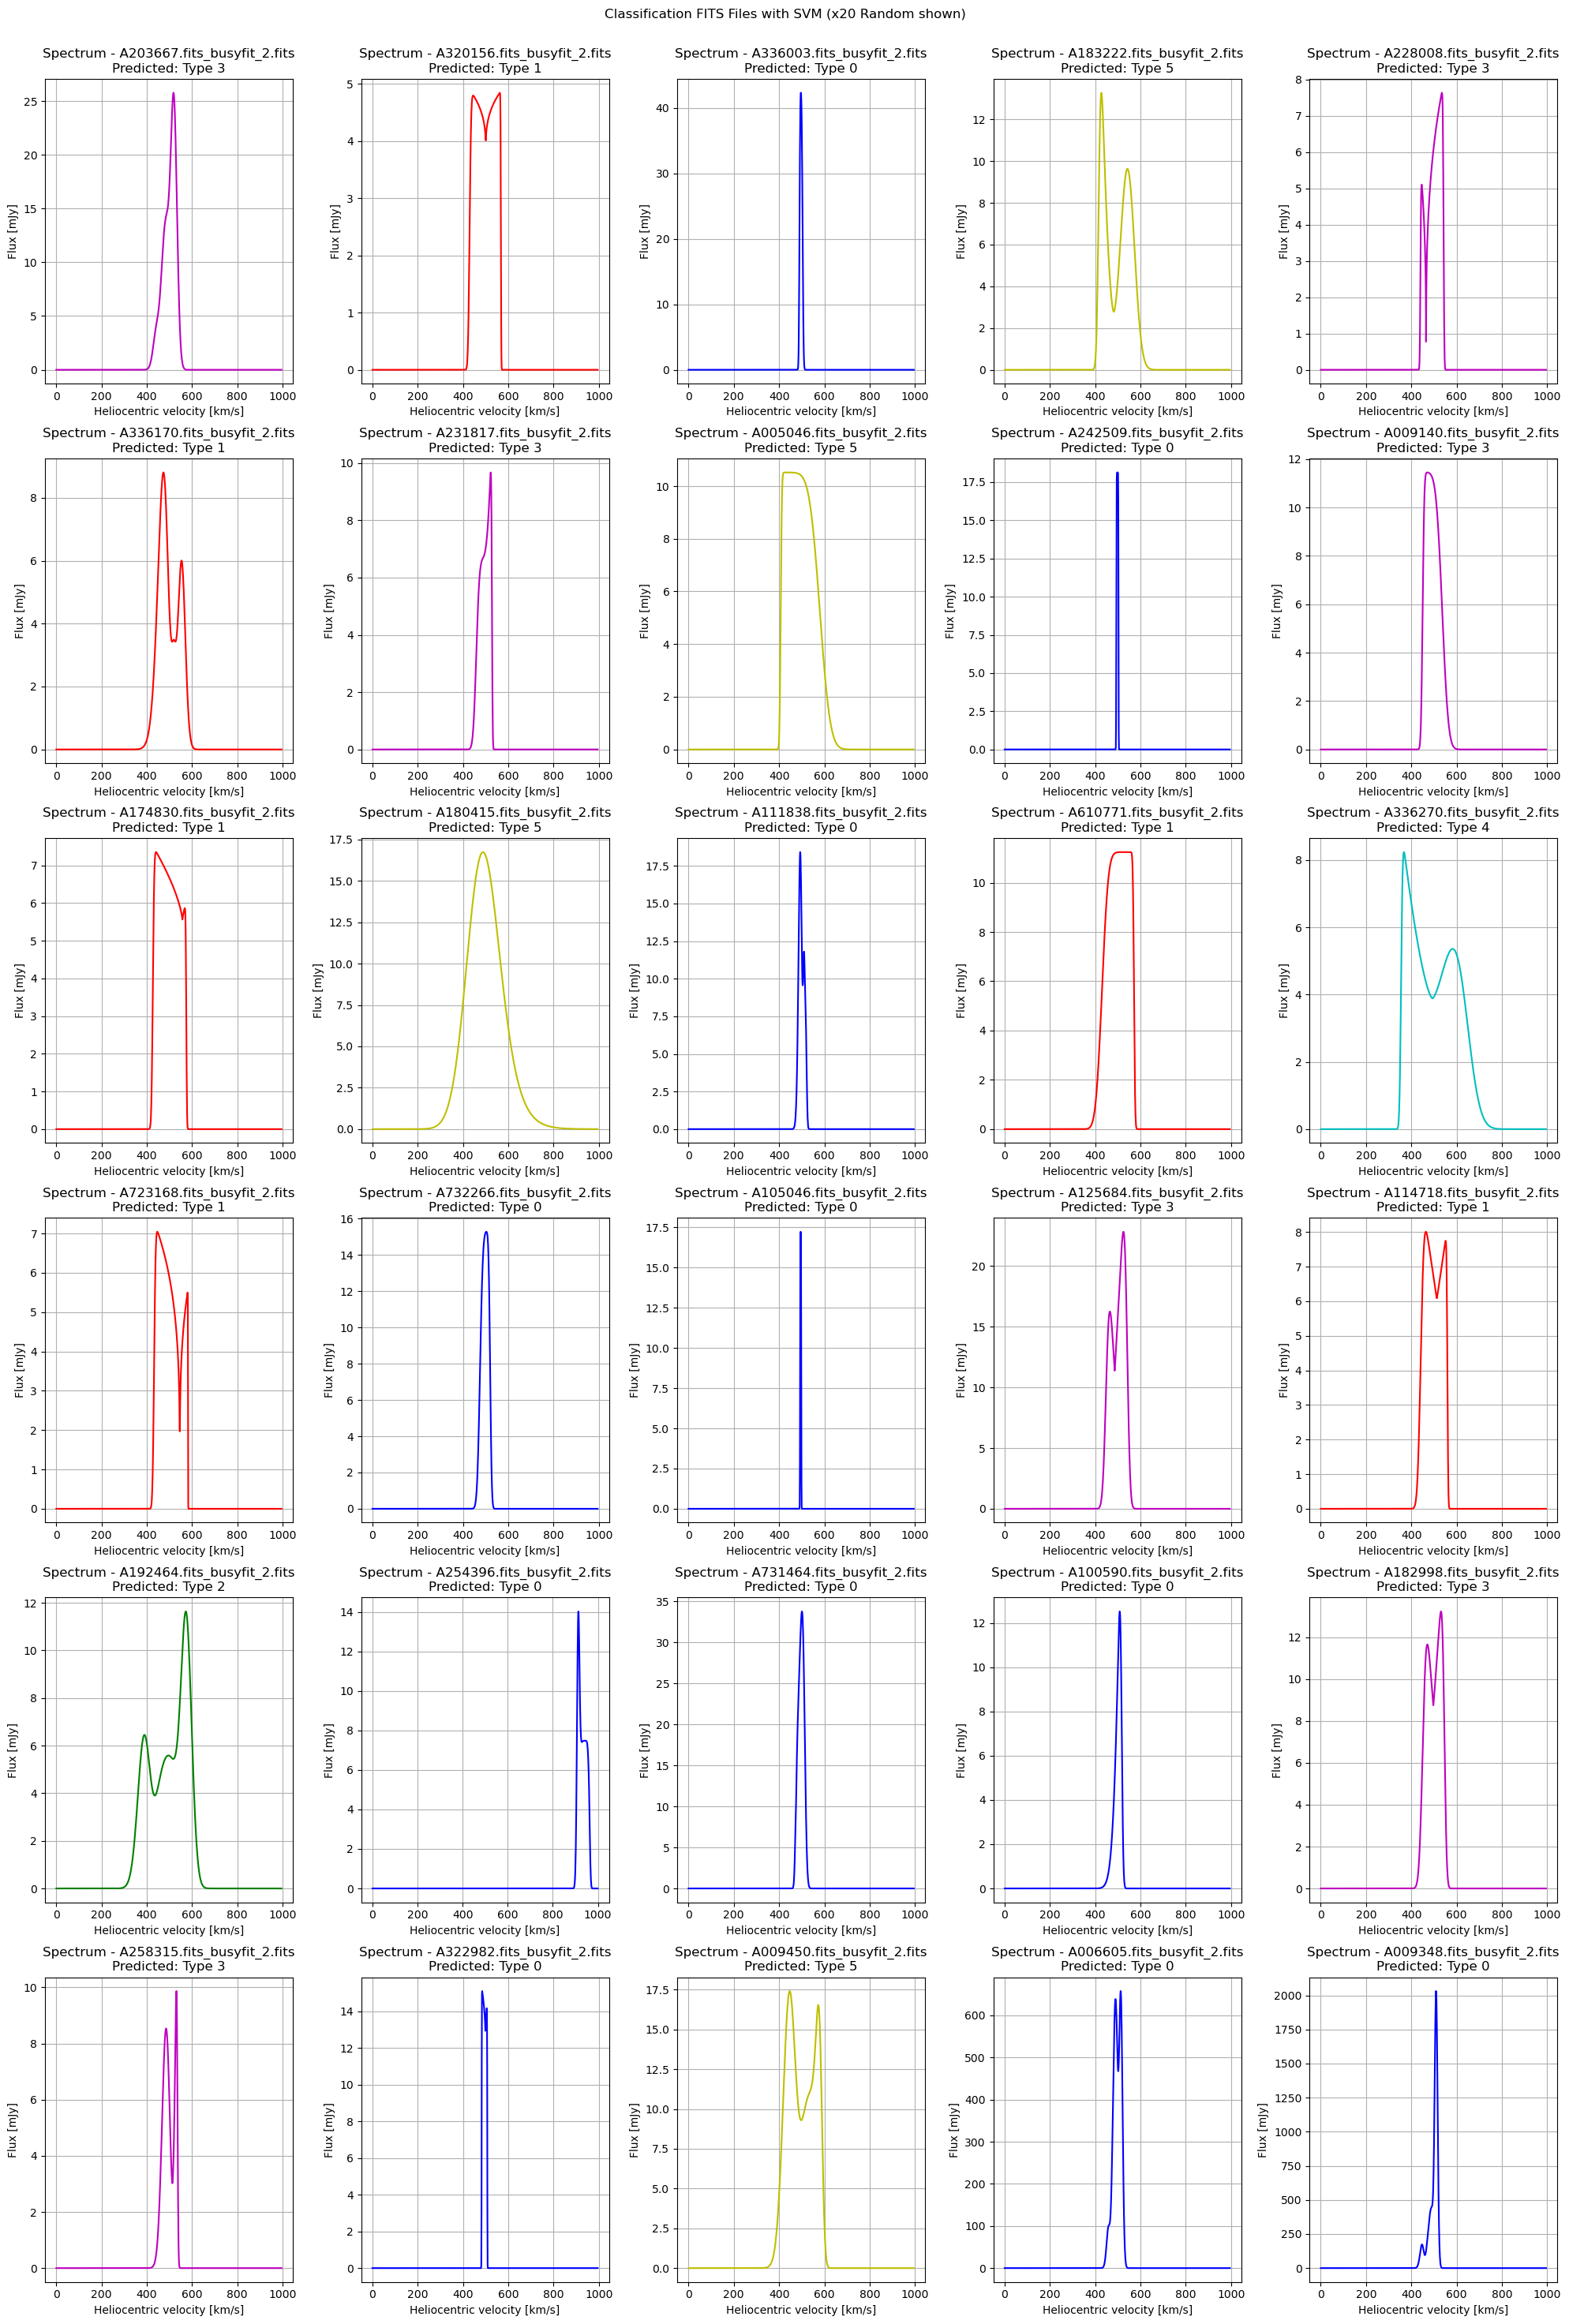

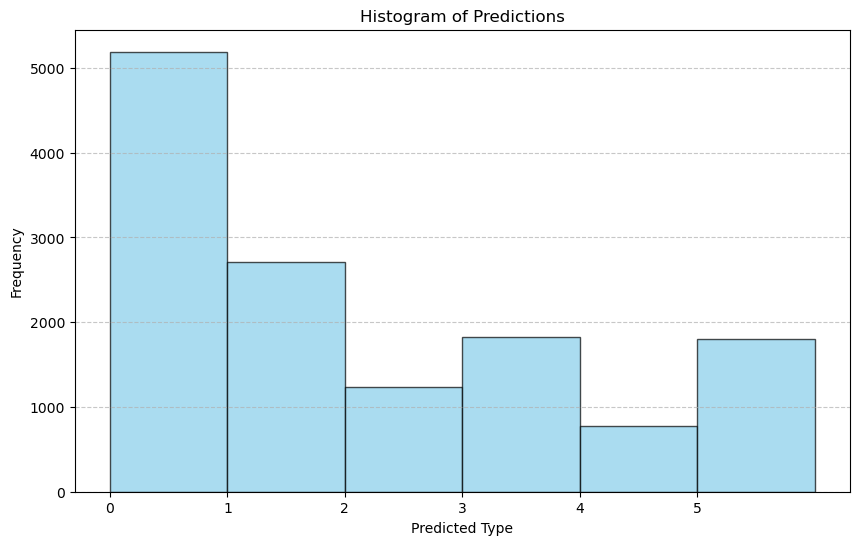

Plots and text saved in filtered_data_alfalfa_classification_SVM_results_shapelets_AgglomerativeClustering_2.pdf


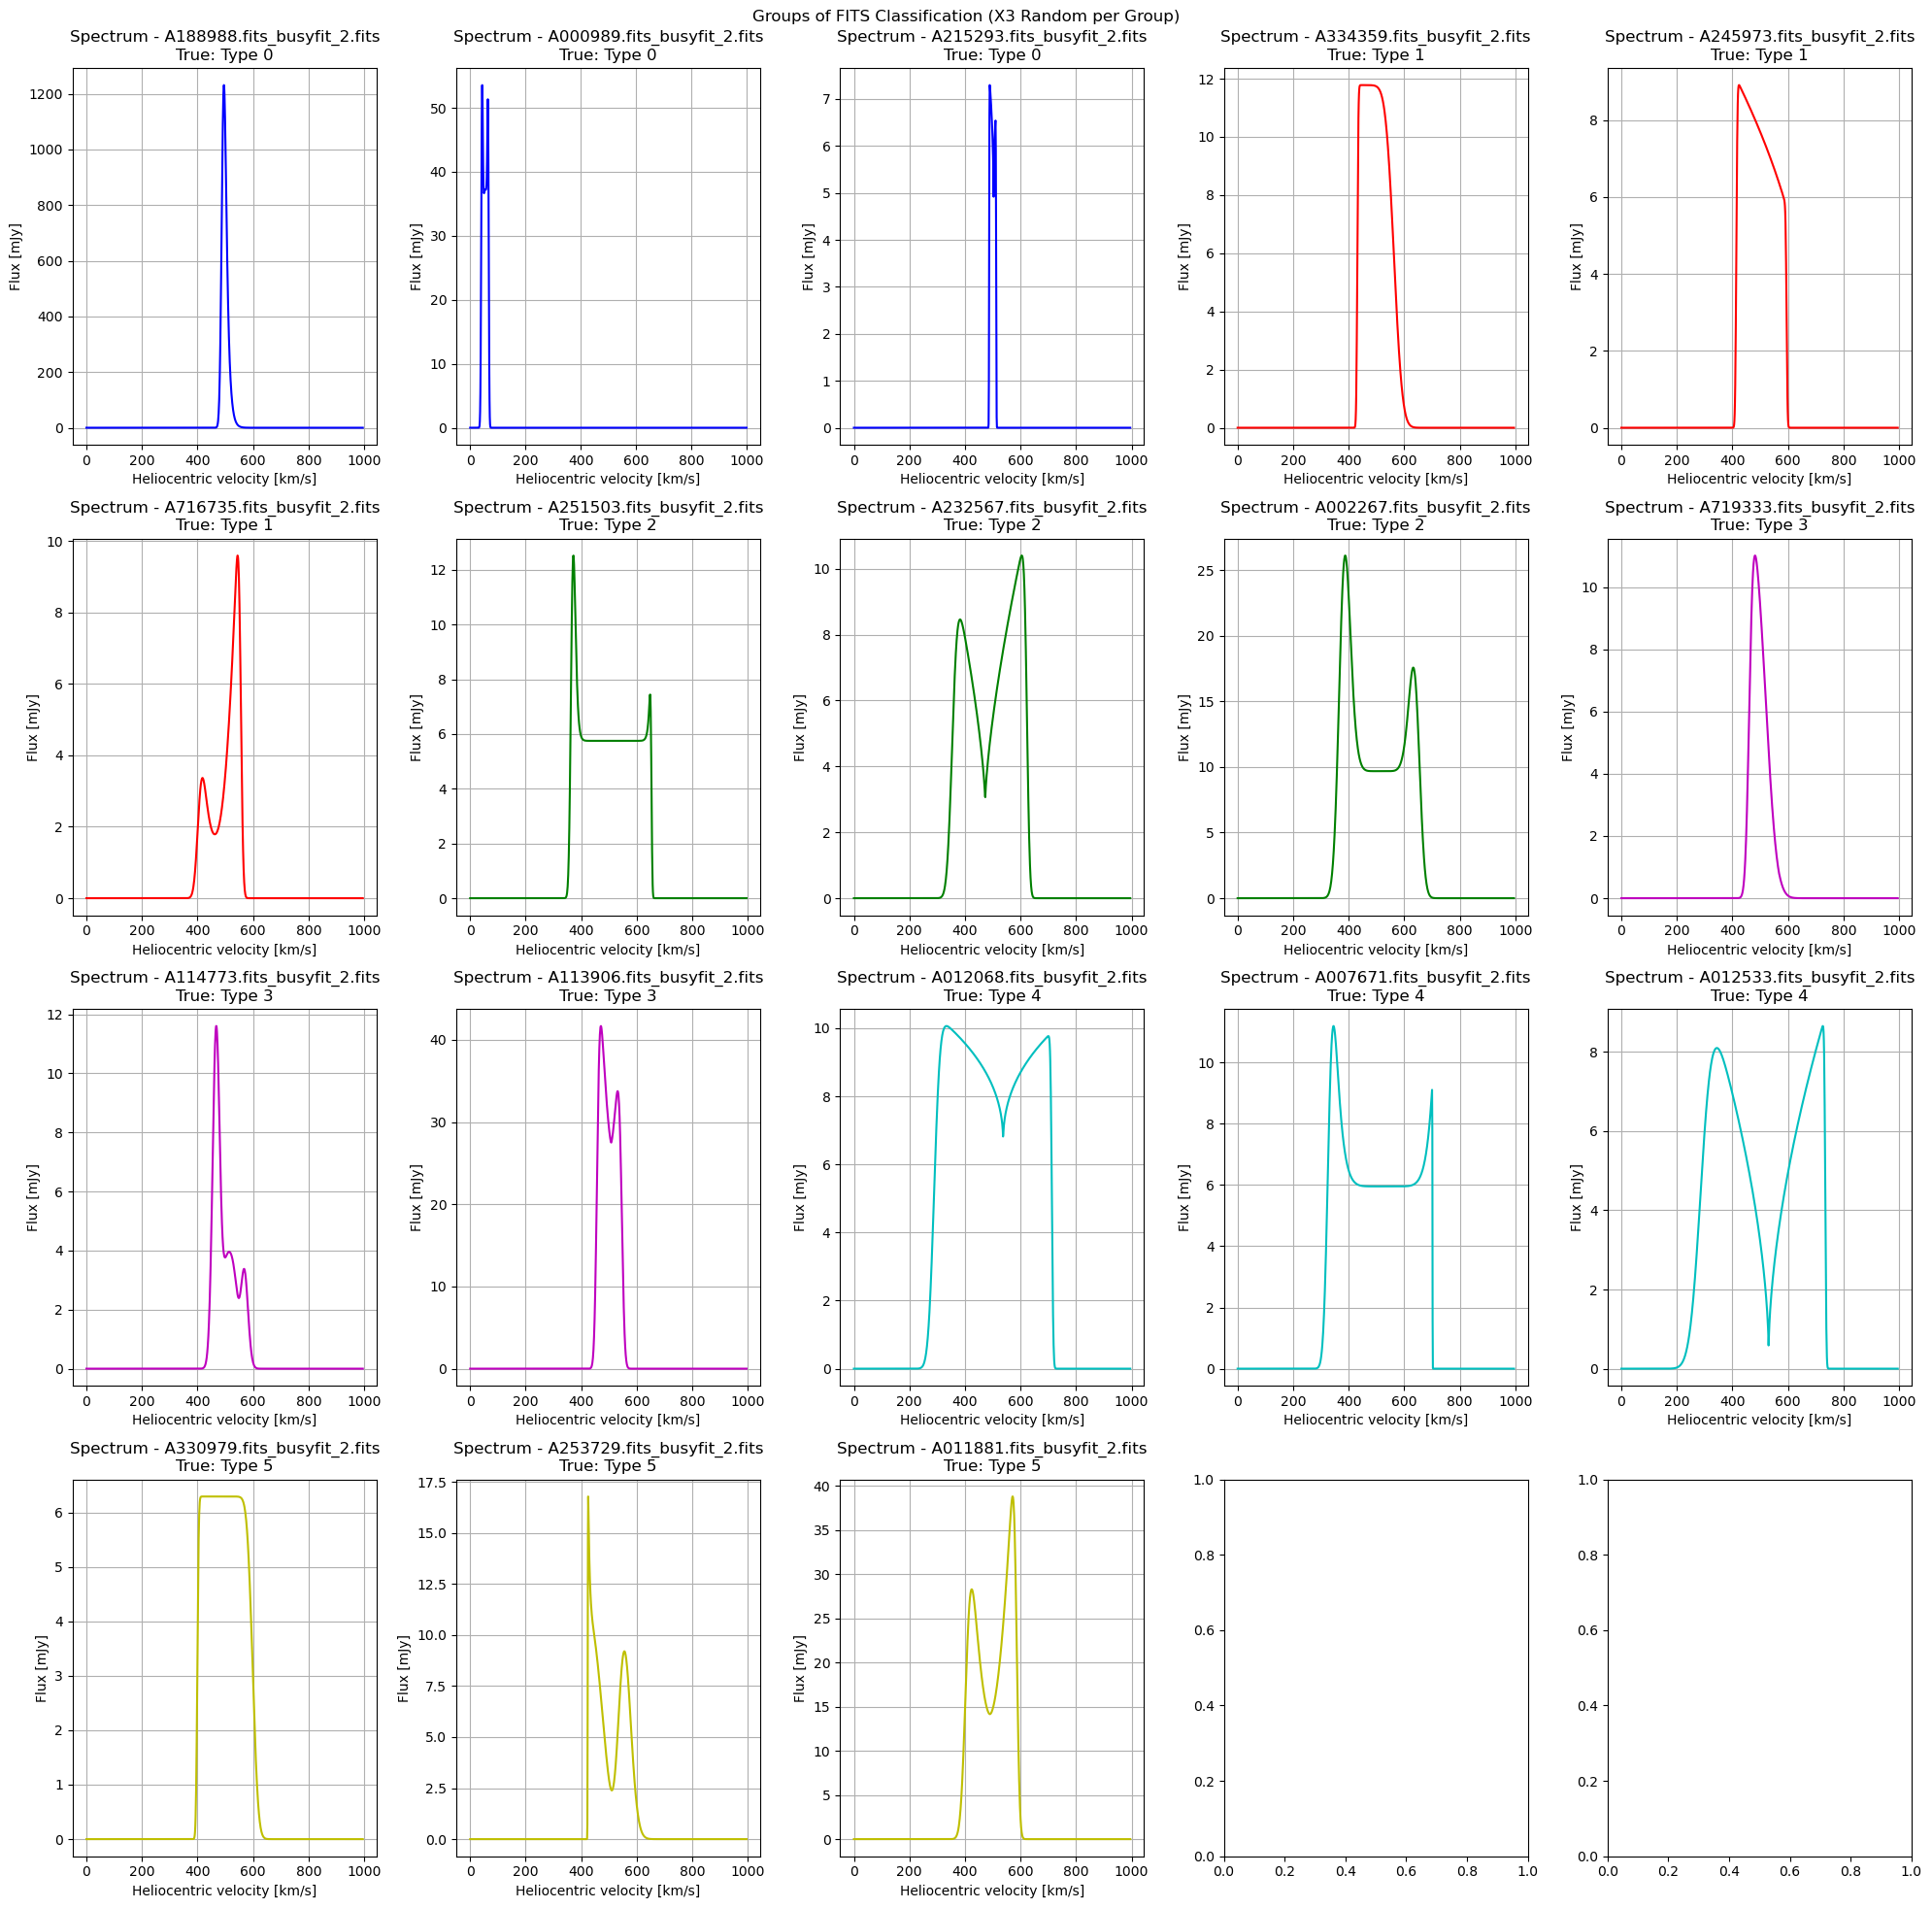

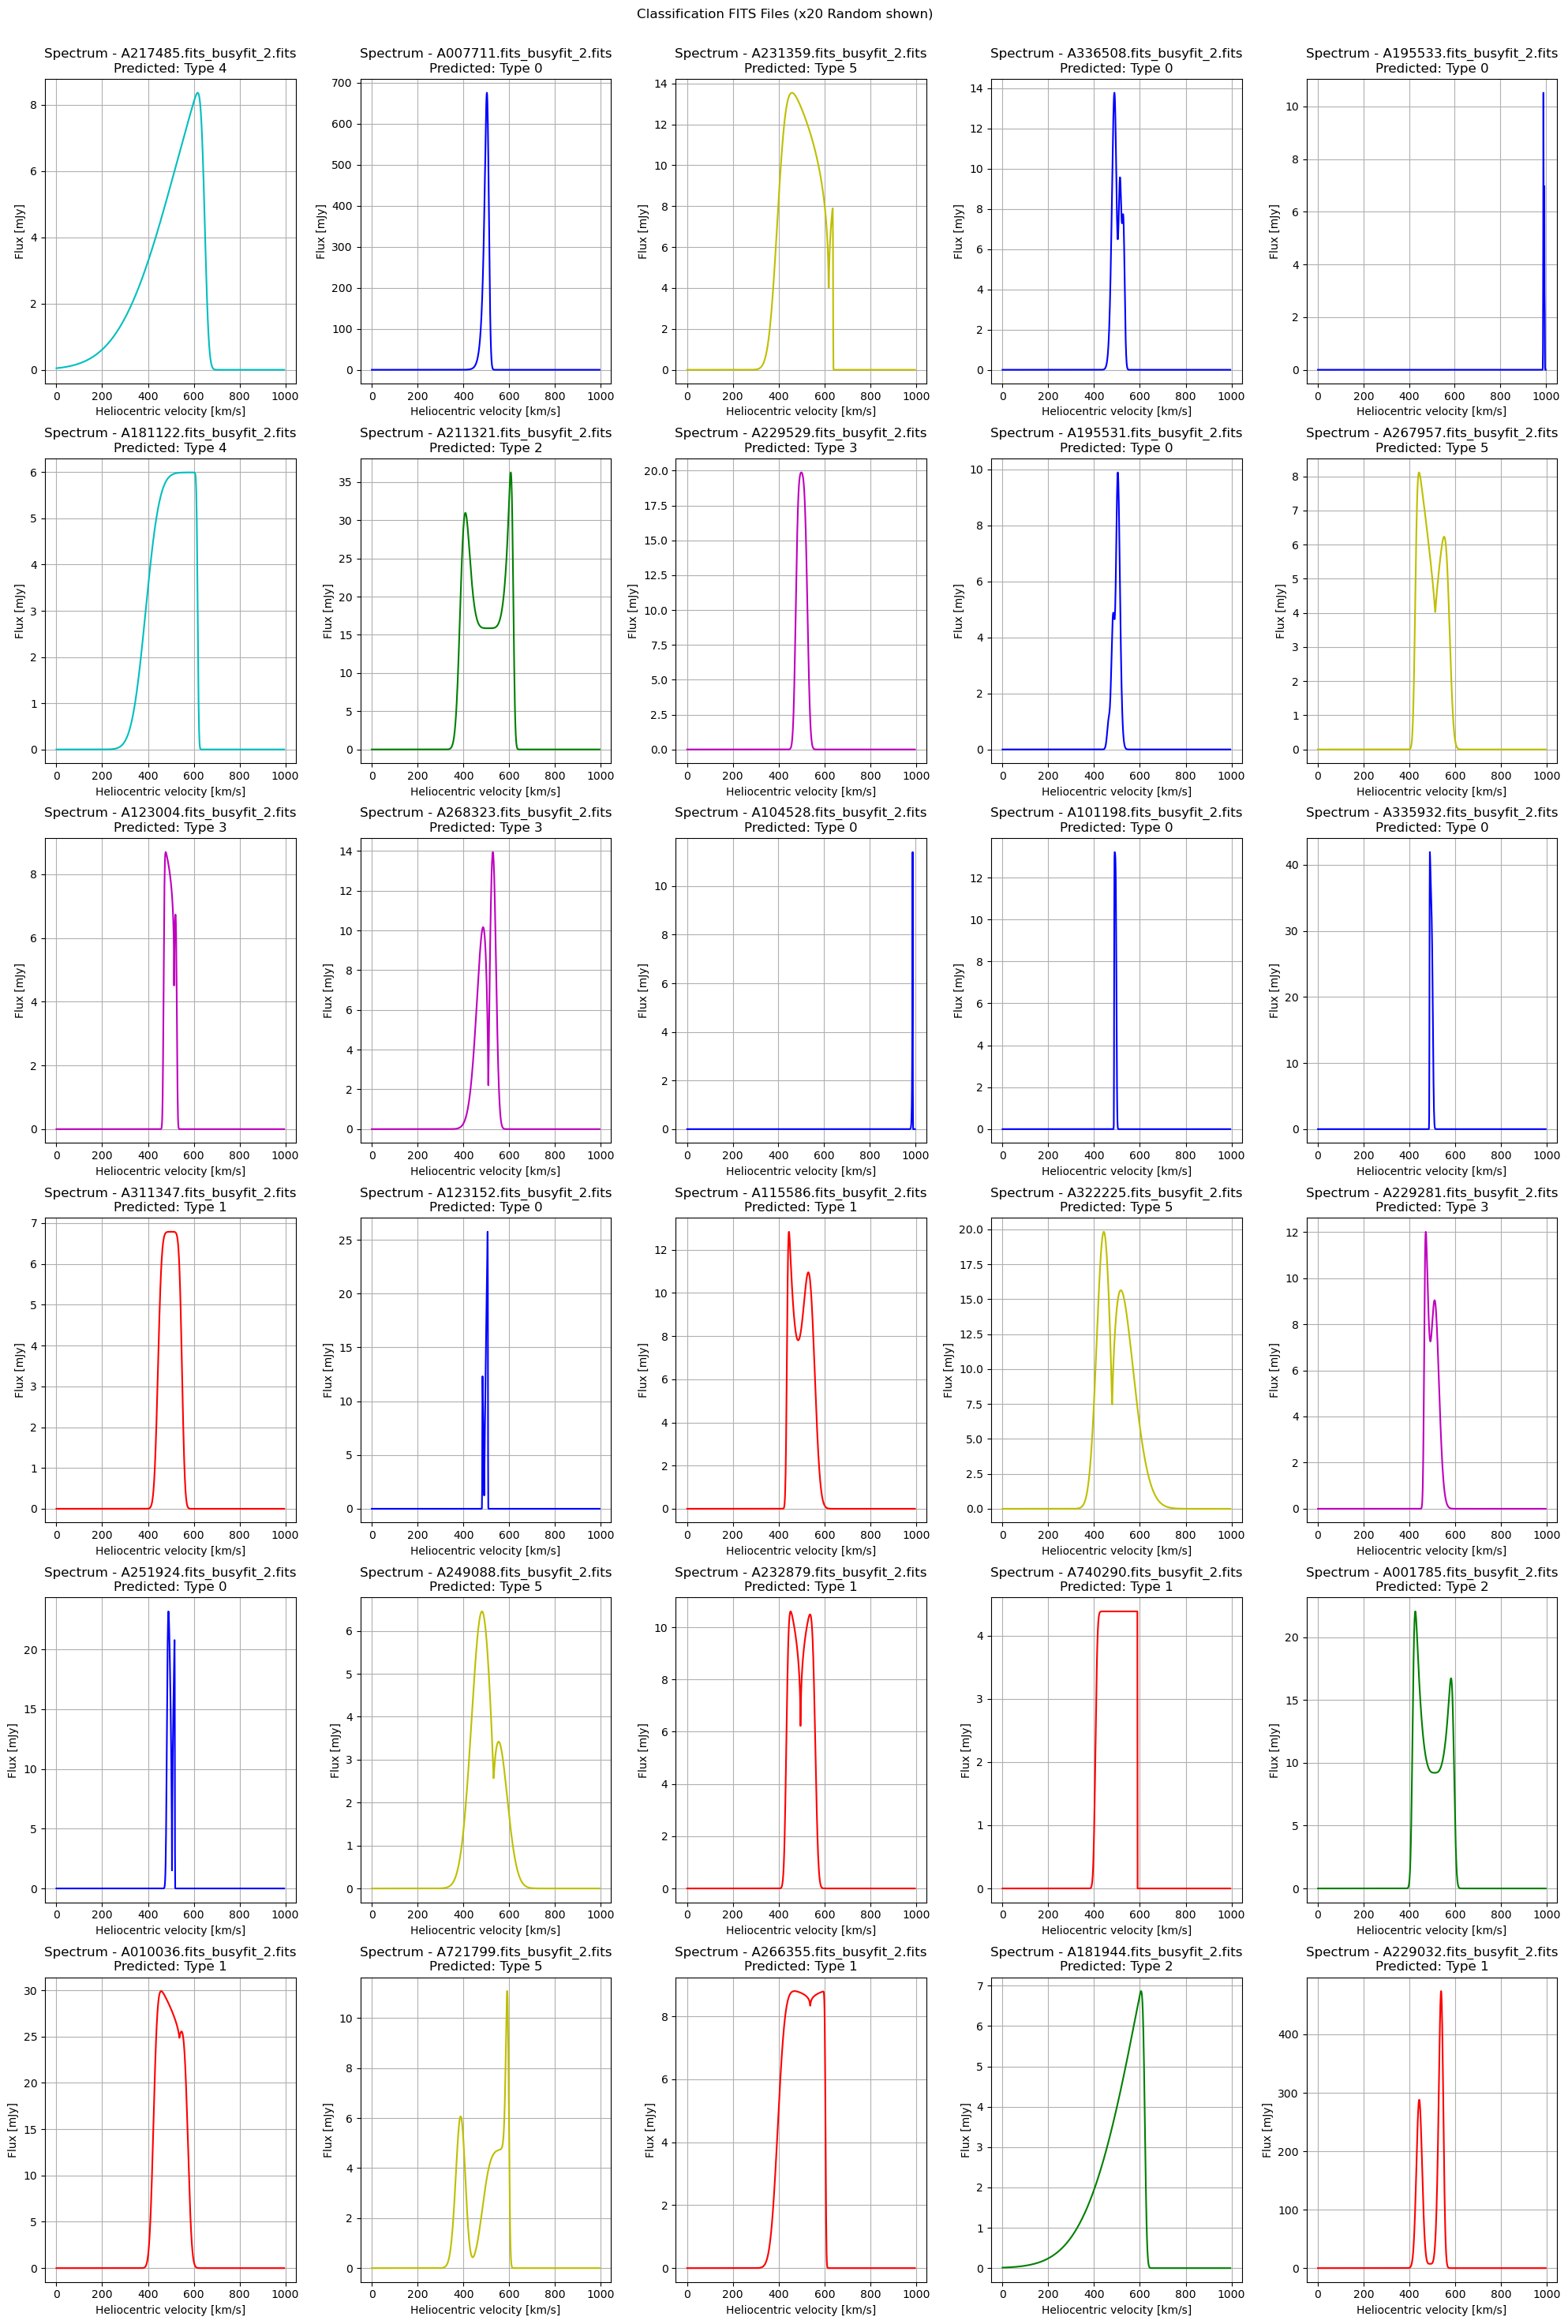

In [10]:
import numpy as np
import pandas as pd
from astropy.io import fits
from tslearn.shapelets import LearningShapelets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, AffinityPropagation, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import glob
import os
import random

# Training variables
clustering_method = "AgglomerativeClustering"  # Specify clustering method: "k_means", "spectral_clustering", "DBSCAN", "AgglomerativeClustering", "MeanShift", "AffinityPropagation", "GaussianMixture"
type_of_classification = "2"
number_max_fits = 35000
percentage_training = 0.25
ngroups = 6

# Change to the FITS data directory
fits_data_directory = 'D:/1. JAE Intro ICU/sp_im_busyfit/'
os.chdir(fits_data_directory)
print("Current Directory:", os.getcwd())

# Function to load data from FITS files
def load_fits_data(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[0].data[0]  # Get data from the first HDU
    return data

# Pre-filter based on 'AGC' column in the .xlsx file
alfalfa_df = pd.read_excel("filtered_data_alfalfa_1.xlsx")
agc_ids = alfalfa_df['AGC'].astype(str).tolist()
formatted_agc_ids = [f"A{agc_id.zfill(6)}" for agc_id in agc_ids]

print(f"Total AGC IDs to filter by: {len(formatted_agc_ids)}")
print("First 20 AGC IDs to filter by:")
print(formatted_agc_ids[:20])

# List and filter FITS files based on AGC IDs
file_paths_total = glob.glob(f'*.fits_busyfit_{type_of_classification}.fits')
print(f"Total FITS files found before filtering: {len(file_paths_total)}")

filtered_file_paths = [fp for fp in file_paths_total if any(agc_id in fp for agc_id in formatted_agc_ids)]
print(f"Total FITS files after filtering: {len(filtered_file_paths)}")

# Limit the number of files to process (if needed)
filtered_file_paths = filtered_file_paths[:number_max_fits]
print(f"Total FITS files after limiting to {number_max_fits}: {len(filtered_file_paths)}")

# Verify some of the filtered FITS files
for fp in filtered_file_paths[:10]:
    print(fp)

# Randomly shuffle and split the filtered FITS files into training and classification sets
random.shuffle(filtered_file_paths)
training_size = round(len(filtered_file_paths) * percentage_training)
file_paths_for_groups = filtered_file_paths[:training_size]
file_paths = filtered_file_paths[training_size:]

print("Selected method for Classification:", clustering_method)
print("Total number of samples:", len(filtered_file_paths))
print(f"Number of samples for group generation ({percentage_training}):", len(file_paths_for_groups))
print(f"Number of samples for classification ({1 - percentage_training}):", len(file_paths))

# Number of files per group (1/4 of FITS)
lgroups = round(len(file_paths) * percentage_training / ngroups)

# Ensure there are enough files for the defined groups
assert ngroups * lgroups <= len(file_paths), "Not enough files for the defined groups"

# Processing additional steps as needed...

#-------- 2. Data Preprocessing ----------
def preprocess_data(file_paths):
    X_all = []
    max_length = 0
    for file in file_paths:
        data = load_fits_data(file)
        if data is not None and len(data) > 0:
            X_all.append(data)
            if len(data) > max_length:
                max_length = len(data)
    # Pad or truncate sequences
    X_all = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_all]
    return X_all, max_length

X_all, max_length = preprocess_data(file_paths)

# Normalization
scaler = TimeSeriesScalerMinMax()
X_all_scaled = scaler.fit_transform(np.array(X_all, dtype=np.float64))

# Ensure X_all_scaled is two-dimensional
X_all_scaled = X_all_scaled.reshape(X_all_scaled.shape[0], -1)

# Apply selected clustering method
if clustering_method == "k_means":
    # Apply K-means clustering to group spectra with similar characteristics
    clustering_model = KMeans(n_clusters=ngroups, random_state=0)
elif clustering_method == "spectral_clustering":
    # Apply Spectral Clustering
    try:
        clustering_model = SpectralClustering(n_clusters=ngroups, random_state=0, affinity='nearest_neighbors', n_neighbors=10)
    except ValueError as e:
        print(f"Error applying SpectralClustering: {e}")
        clustering_model = None
elif clustering_method == "DBSCAN":
    # Apply DBSCAN
    clustering_model = DBSCAN(eps=0.5, min_samples=5)
elif clustering_method == "AgglomerativeClustering":
    # Apply Agglomerative Clustering
    clustering_model = AgglomerativeClustering(n_clusters=ngroups)
elif clustering_method == "MeanShift":
    # Apply Mean Shift
    clustering_model = MeanShift()
elif clustering_method == "AffinityPropagation":
    # Apply Affinity Propagation
    clustering_model = AffinityPropagation()
elif clustering_method == "GaussianMixture":
    # Apply Gaussian Mixture Model
    clustering_model = GaussianMixture(n_components=ngroups)
else:
    raise ValueError("Unsupported clustering method specified.")

if clustering_method in ["MeanShift", "AffinityPropagation", "GaussianMixture"]:
    # Fit the model and predict
    clustering_model.fit(X_all_scaled)
    if clustering_method == "GaussianMixture":
        y_all = clustering_model.predict(X_all_scaled)
    else:
        y_all = clustering_model.predict(X_all_scaled)
else:
    # Fit the model and predict
    y_all = clustering_model.fit_predict(X_all_scaled)

# Check if clustering was successful
if len(set(y_all)) < ngroups:
    raise ValueError("El método de clustering no generó suficientes grupos.")

# Select the first `ngroups * lgroups` files for training
X_train = []
y_train = []
for group in range(ngroups):
    indices = np.where(y_all == group)[0][:lgroups]
    if len(indices) > 0:
        X_train.extend([X_all[idx] for idx in indices])
        y_train.extend([group] * len(indices))
    else:
        print(f"Grupo {group} está vacío y no se incluirá en el entrenamiento.")

# Use the remaining files for testing
X_test = [X_all[idx] for idx in range(len(X_all)) if idx not in np.concatenate([np.where(y_all == group)[0][:lgroups] for group in range(ngroups)])]

# Ensure all sequences have the same length
X_train = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_train]
X_test = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_test]

# Verify if X_train and y_train are not empty
if not X_train or not y_train:
    raise ValueError("X_train or y_train are empty. Check input data.")

# Ensure X_train is a 2D array
X_train = np.array(X_train, dtype=np.float64)
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)

# Verify the length of y_train
if len(y_train) != len(X_train):
    raise ValueError("The length of y_train does not match the length of X_train.")

# Convert y_train to a numpy array if it is not already
y_train = np.array(y_train)

# Define colors for each group
colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k', 'orange']  # Extend this list if you have more than 8 groups

#-------- 3. Model Training ----------
# Train shapelets model
model = LearningShapelets(n_shapelets_per_size={100: 10, 50: 8, 30: 5, 10: 3}, max_iter=350, batch_size=10, scale=True)
model.fit(X_train, y_train)


#-------- 4. FITS Files Visualization ----------
def plot_fits_spectra(file_paths, title, labels=None, predictions=None, num_columns=5):
    num_files = len(file_paths)
    num_rows = (num_files + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    for i, file_path in enumerate(file_paths):
        with fits.open(file_path) as fits_file:
            spectrum_data = fits_file[0].data
            spectrum_data = np.squeeze(spectrum_data)
        wavelength = np.arange(len(spectrum_data))
        ax = axes[i // num_columns, i % num_columns]
        if predictions is not None:
            color = colors[predictions[i]]
            label = f'Predicted: Type {predictions[i]}'
        elif labels is not None:
            color = colors[labels[i]]
            label = f'True: Type {labels[i]}'
        else:
            color = 'b'
            label = ''
        ax.plot(wavelength, spectrum_data, color=color)
        ax.set_xlabel('Heliocentric velocity [km/s]')
        ax.set_ylabel('Flux [mJy]')
        ax.set_title(f'Spectrum - {file_path}\n{label}')
        ax.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig
def plot_fits_spectra_random(file_paths, title, labels=None, predictions=None, num_columns=5, num_plots=30):
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    random_indices = np.random.choice(len(file_paths), num_plots, replace=False)
    for i, idx in enumerate(random_indices):
        file_path = file_paths[idx]
        with fits.open(file_path) as hdul:
            data_spectrum = hdul[0].data
            data_spectrum = np.squeeze(data_spectrum)
        velocity = np.arange(len(data_spectrum))
        ax = axes[i // num_columns, i % num_columns]
        if predictions is not None:
            color = colors[predictions[idx]]
            label = f'Predicted: Type {predictions[idx]}'
        elif labels is not None:
            color = colors[labels[idx]]
            label = f'True: Type {labels[idx]}'
        else:
            color = 'b'
            label = ''
        ax.plot(velocity, data_spectrum, color=color)
        ax.set_xlabel('Heliocentric velocity [km/s]')
        ax.set_ylabel('Flux [mJy]')
        ax.set_title(f'Spectrum - {file_path}\n{label}')
        ax.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

def plot_random_samples_per_group(file_paths, y_all, y_train, ngroups, num_samples=3):
    selected_files = []
    selected_labels = []
    
    for group in range(ngroups):
        group_indices = np.where(y_all == group)[0]
        actual_num_samples = min(num_samples, len(group_indices))
        
        if actual_num_samples > 0:
            selected_indices = np.random.choice(group_indices, actual_num_samples, replace=False)
            selected_files.extend([file_paths[idx] for idx in selected_indices])
            selected_labels.extend([group] * actual_num_samples)
        else:
            print(f"Warning: Group {group} does not have enough elements to select {num_samples} samples.")
    
    return plot_fits_spectra(selected_files, title="Groups of FITS Classification (X3 Random per Group)", labels=selected_labels)


#-------- 5. Model Evaluation ----------

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Scale the test data
X_test_scaled = scaler.transform(np.array(X_test, dtype=np.float64))
X_test_transformed = model.transform(X_test_scaled)

# Scale and transform the training data
X_train_transformed = model.transform(X_train)

# Define hyperparameters for SVM tuning
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

# Define the SVM model
svm = SVC()

# Perform hyperparameter search with cross-validation
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5)
grid_svm.fit(X_train_transformed, y_train)

# Get the best SVM model
best_svm = grid_svm.best_estimator_

# Predictions with the best SVM model
y_pred = best_svm.predict(X_test_transformed)

# Visualize test data with SVM predictions
test_file_paths = [file_paths[idx] for idx in range(len(file_paths)) if idx not in np.concatenate([np.where(y_all == group)[0][:lgroups] for group in range(ngroups)])]
plot_fits_spectra_random(test_file_paths, title="Classification FITS Files with SVM (x20 Random shown)", predictions=y_pred, num_columns=5, num_plots=30)

#-------- 6. Classification Results ----------

# Crear un diccionario para mapear archivos a sus clasificaciones
file_to_classification = {file: prediction for file, prediction in zip(test_file_paths, y_pred)}

# Inicializar la columna 'Classification' con None
alfalfa_df['Classification'] = None

# Asignar las clasificaciones a los AGC IDs correspondientes en el DataFrame
for idx, row in alfalfa_df.iterrows():
    agc_id = str(row['AGC'])
    # Encontrar el archivo FITS que contiene el ID AGC
    matched_file = next((file for file in file_paths_total if agc_id in file), None)
    if matched_file and matched_file in file_to_classification:
        alfalfa_df.at[idx, 'Classification'] = file_to_classification[matched_file]

# Verificar si hay clasificaciones faltantes
missing_classifications = alfalfa_df[alfalfa_df['Classification'].isna()]
if not missing_classifications.empty:
    print("Se encontraron archivos sin clasificación:")
    print(missing_classifications)

# Guardar el DataFrame actualizado en un archivo Excel
result_file_path = f"filtered_data_alfalfa_classification_SVM_results_shapelets_{clustering_method}_{type_of_classification}.xlsx"
alfalfa_df.to_excel(result_file_path, index=False)

print(f"\nClasificaciones guardadas en: {result_file_path}")

# Imprimir la matriz de confusión y el informe de clasificación
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, model.predict(X_train)))
print("\nClassification Report:")
print(classification_report(y_train, model.predict(X_train)))

# Visualizar el histograma de predicciones
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=range(ngroups + 1), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Predictions')
plt.xlabel('Predicted Type')
plt.ylabel('Frequency')
plt.xticks(range(ngroups))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plot_random_samples_per_group(file_paths, y_all, y_train, ngroups)
plot_fits_spectra_random(test_file_paths, title="Classification FITS Files (x20 Random shown)", predictions=y_pred, num_columns=5, num_plots=30)

#-------- 7. Save as PDF Document ----------
from matplotlib.backends.backend_pdf import PdfPages
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from io import BytesIO
from PyPDF2 import PdfReader, PdfWriter  # Ensure you have PyPDF2 installed

# Create a PDF file
output_pdf_path = f"filtered_data_alfalfa_classification_SVM_results_shapelets_{clustering_method}_{type_of_classification}.pdf"

# Create a buffer for the text
packet = BytesIO()
can = canvas.Canvas(packet, pagesize=letter)

# Add text to the PDF
can.drawString(72, 720, f"Current Directory: {fits_data_directory}")
can.drawString(72, 705, f"Total AGC IDs to filter by: {len(formatted_agc_ids)}")
can.drawString(72, 690, "First 20 AGC IDs to filter by:")
for i, agc_id in enumerate(formatted_agc_ids[:20]):
    can.drawString(72, 675 - i*15, agc_id)

can.drawString(72, 360, f"Total FITS files found before filtering: {len(file_paths_total)}")
can.drawString(72, 345, f"Total FITS files after filtering: {len(filtered_file_paths)}")
can.drawString(72, 330, f"Total FITS files after limiting to {number_max_fits}: {len(filtered_file_paths)}")

random.shuffle(filtered_file_paths)
training_size = round(len(filtered_file_paths) * percentage_training)
file_paths_for_groups = filtered_file_paths[:training_size]
file_paths = filtered_file_paths[training_size:]

can.drawString(72, 315, f"Selected method for Classification: {clustering_method}")
can.drawString(72, 300, f"Total number of samples: {len(filtered_file_paths)}")
can.drawString(72, 285, f"Number of samples for group generation ({percentage_training}): {len(file_paths_for_groups)}")
can.drawString(72, 270, f"Number of samples for classification ({1 - percentage_training}): {len(file_paths)}")

lgroups = round(len(file_paths) * percentage_training / ngroups)
can.drawString(72, 255, f"Number of files per group: {lgroups}")

# Add additional text
can.drawString(72, 240, f"Train shapelets model:")
can.drawString(72, 225, f"model = LearningShapelets(n_shapelets_per_size={{100: 10, 50: 8, 30: 5, 10: 3}}, max_iter=350, batch_size=10, scale=True)")
can.drawString(72, 210, f"model.fit(X_train, y_train)")

can.drawString(72, 195, f"Classification using KNN:")
can.drawString(72, 180, f"knn = KNeighborsClassifier(n_neighbors=1)")
can.drawString(72, 165, f"knn.fit(model.transform(X_train), y_train)")
can.drawString(72, 150, f"y_pred = knn.predict(X_test_transformed)")

can.save()
packet.seek(0)

# Read the content of the created text page
new_pdf = PdfReader(packet)
first_page = new_pdf.pages[0]

# Generate all the plots

# Create and save plots in the final PDF file
with PdfWriter(output_pdf_path) as pdf_writer:
    # Add the text page
    pdf_writer.add_page(first_page)
    
    # Create a buffer to save plots
    plot_buffer = BytesIO()
    with PdfPages(plot_buffer) as pdf:
        # Save generated plots

        fig1 = plot_random_samples_per_group(file_paths, y_all, y_train, ngroups)
        pdf.savefig(fig1)
        plt.close(fig1)  # Close the plot to free memory
        
        fig2 = plot_fits_spectra_random(test_file_paths, title="Classification FITS Files (x20 Random shown)", predictions=y_pred, num_columns=5, num_plots=30)
        pdf.savefig(fig2)
        plt.close(fig2)  # Close the plot to free memory

        # Save the histogram of predictions
        fig3 = plt.figure(figsize=(10, 6))
        plt.hist(y_pred, bins=range(ngroups + 1), color='skyblue', edgecolor='black', alpha=0.7)
        plt.title('Histogram of Predictions')
        plt.xlabel('Predicted Type')
        plt.ylabel('Frequency')
        plt.xticks(range(ngroups))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        pdf.savefig(fig3)
        plt.close(fig3)  # Close the histogram to free memory

    # Read the content of the plot buffer and add to the final PDF
    plot_buffer.seek(0)
    plot_pdf = PdfReader(plot_buffer)
    for page in plot_pdf.pages:
        pdf_writer.add_page(page)

# Print a message indicating that the PDF file has been saved
print(f'Plots and text saved in {output_pdf_path}')




---

### Step 3: Random Forest Classification - Shapelets | ALFALFA

This code processes and classifies astronomical data using Random Forest, starting with reading FITS files and filtering them based on AGC IDs from an Excel file. The data is shuffled and split into training and testing sets, followed by normalization. Different clustering techniques (K-Means, DBSCAN, etc.) are applied to group data into clusters. A Shapelets model is trained using the groups. Random Forest is then used for classification, with hyperparameter tuning performed using GridSearchCV. The model's performance is evaluated through confusion matrices and classification reports, and visualizations, including random spectra samples, are saved in a PDF file.

In [ ]:
import numpy as np
import pandas as pd
from astropy.io import fits
from tslearn.shapelets import LearningShapelets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, AffinityPropagation, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import glob
import os
import random

# Training variables
clustering_method = "spectral_clustering"  # Specify clustering method: "k_means", "spectral_clustering", "DBSCAN", "AgglomerativeClustering", "MeanShift", "AffinityPropagation", "GaussianMixture"
type_of_classification = "2"
number_max_fits = 35000
percentage_training = 0.25
ngroups = 6

# Change to the FITS data directory
fits_data_directory = 'D:/1. JAE Intro ICU/sp_im_busyfit/'
os.chdir(fits_data_directory)
print("Current Directory:", os.getcwd())

# Function to load data from FITS files
def load_fits_data(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[0].data[0]  # Get data from the first HDU
    return data

# Pre-filter based on 'AGC' column in the .xlsx file
alfalfa_df = pd.read_excel("filtered_data_alfalfa_1.xlsx")
agc_ids = alfalfa_df['AGC'].astype(str).tolist()
formatted_agc_ids = [f"A{agc_id.zfill(6)}" for agc_id in agc_ids]

print(f"Total AGC IDs to filter by: {len(formatted_agc_ids)}")
print("First 20 AGC IDs to filter by:")
print(formatted_agc_ids[:20])

# List and filter FITS files based on AGC IDs
file_paths_total = glob.glob(f'*.fits_busyfit_{type_of_classification}.fits')
print(f"Total FITS files found before filtering: {len(file_paths_total)}")

filtered_file_paths = [fp for fp in file_paths_total if any(agc_id in fp for agc_id in formatted_agc_ids)]
print(f"Total FITS files after filtering: {len(filtered_file_paths)}")

# Limit the number of files to process (if needed)
filtered_file_paths = filtered_file_paths[:number_max_fits]
print(f"Total FITS files after limiting to {number_max_fits}: {len(filtered_file_paths)}")

# Verify some of the filtered FITS files
for fp in filtered_file_paths[:10]:
    print(fp)

# Randomly shuffle and split the filtered FITS files into training and classification sets
random.shuffle(filtered_file_paths)
training_size = round(len(filtered_file_paths) * percentage_training)
file_paths_for_groups = filtered_file_paths[:training_size]
file_paths = filtered_file_paths[training_size:]

print("Selected method for Classification:", clustering_method)
print("Total number of samples:", len(filtered_file_paths))
print(f"Number of samples for group generation ({percentage_training}):", len(file_paths_for_groups))
print(f"Number of samples for classification ({1 - percentage_training}):", len(file_paths))

# Number of files per group (1/4 of FITS)
lgroups = round(len(file_paths) * percentage_training / ngroups)

# Ensure there are enough files for the defined groups
assert ngroups * lgroups <= len(file_paths), "Not enough files for the defined groups"

# Processing additional steps as needed...

#-------- 2. Data Preprocessing ----------
def preprocess_data(file_paths):
    X_all = []
    max_length = 0
    for file in file_paths:
        data = load_fits_data(file)
        if data is not None and len(data) > 0:
            X_all.append(data)
            if len(data) > max_length:
                max_length = len(data)
    # Pad or truncate sequences
    X_all = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_all]
    return X_all, max_length

X_all, max_length = preprocess_data(file_paths)

# Normalization
scaler = TimeSeriesScalerMinMax()
X_all_scaled = scaler.fit_transform(np.array(X_all, dtype=np.float64))

# Ensure X_all_scaled is two-dimensional
X_all_scaled = X_all_scaled.reshape(X_all_scaled.shape[0], -1)

# Apply selected clustering method
if clustering_method == "k_means":
    # Apply K-means clustering to group spectra with similar characteristics
    clustering_model = KMeans(n_clusters=ngroups, random_state=0)
elif clustering_method == "spectral_clustering":
    # Apply Spectral Clustering
    try:
        clustering_model = SpectralClustering(n_clusters=ngroups, random_state=0, affinity='nearest_neighbors', n_neighbors=10)
    except ValueError as e:
        print(f"Error applying SpectralClustering: {e}")
        clustering_model = None
elif clustering_method == "DBSCAN":
    # Apply DBSCAN
    clustering_model = DBSCAN(eps=0.5, min_samples=5)
elif clustering_method == "AgglomerativeClustering":
    # Apply Agglomerative Clustering
    clustering_model = AgglomerativeClustering(n_clusters=ngroups)
elif clustering_method == "MeanShift":
    # Apply Mean Shift
    clustering_model = MeanShift()
elif clustering_method == "AffinityPropagation":
    # Apply Affinity Propagation
    clustering_model = AffinityPropagation()
elif clustering_method == "GaussianMixture":
    # Apply Gaussian Mixture Model
    clustering_model = GaussianMixture(n_components=ngroups)
else:
    raise ValueError("Unsupported clustering method specified.")

if clustering_method in ["MeanShift", "AffinityPropagation", "GaussianMixture"]:
    # Fit the model and predict
    clustering_model.fit(X_all_scaled)
    if clustering_method == "GaussianMixture":
        y_all = clustering_model.predict(X_all_scaled)
    else:
        y_all = clustering_model.predict(X_all_scaled)
else:
    # Fit the model and predict
    y_all = clustering_model.fit_predict(X_all_scaled)

# Check if clustering was successful
if len(set(y_all)) < ngroups:
    raise ValueError("El método de clustering no generó suficientes grupos.")

# Select the first `ngroups * lgroups` files for training
X_train = []
y_train = []
for group in range(ngroups):
    indices = np.where(y_all == group)[0][:lgroups]
    if len(indices) > 0:
        X_train.extend([X_all[idx] for idx in indices])
        y_train.extend([group] * len(indices))
    else:
        print(f"Grupo {group} está vacío y no se incluirá en el entrenamiento.")

# Use the remaining files for testing
X_test = [X_all[idx] for idx in range(len(X_all)) if idx not in np.concatenate([np.where(y_all == group)[0][:lgroups] for group in range(ngroups)])]

# Ensure all sequences have the same length
X_train = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_train]
X_test = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_test]

# Verify if X_train and y_train are not empty
if not X_train or not y_train:
    raise ValueError("X_train or y_train are empty. Check input data.")

# Ensure X_train is a 2D array
X_train = np.array(X_train, dtype=np.float64)
if X_train.ndim == 1:
    X_train = X_train.reshape(-1, 1)

# Verify the length of y_train
if len(y_train) != len(X_train):
    raise ValueError("The length of y_train does not match the length of X_train.")

# Convert y_train to a numpy array if it is not already
y_train = np.array(y_train)

# Define colors for each group
colors = ['b', 'r', 'g', 'm', 'c', 'y', 'k', 'orange']  # Extend this list if you have more than 8 groups

#-------- 3. Model Training ----------
# Train shapelets model
model = LearningShapelets(n_shapelets_per_size={100: 10, 50: 8, 30: 5, 10: 3}, max_iter=350, batch_size=10, scale=True)
model.fit(X_train, y_train)


#-------- 4. FITS Files Visualization ----------
def plot_fits_spectra(file_paths, title, labels=None, predictions=None, num_columns=5):
    num_files = len(file_paths)
    num_rows = (num_files + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    for i, file_path in enumerate(file_paths):
        with fits.open(file_path) as fits_file:
            spectrum_data = fits_file[0].data
            spectrum_data = np.squeeze(spectrum_data)
        wavelength = np.arange(len(spectrum_data))
        ax = axes[i // num_columns, i % num_columns]
        if predictions is not None:
            color = colors[predictions[i]]
            label = f'Predicted: Type {predictions[i]}'
        elif labels is not None:
            color = colors[labels[i]]
            label = f'True: Type {labels[i]}'
        else:
            color = 'b'
            label = ''
        ax.plot(wavelength, spectrum_data, color=color)
        ax.set_xlabel('Heliocentric velocity [km/s]')
        ax.set_ylabel('Flux [mJy]')
        ax.set_title(f'Spectrum - {file_path}\n{label}')
        ax.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig
def plot_fits_spectra_random(file_paths, title, labels=None, predictions=None, num_columns=5, num_plots=30):
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    random_indices = np.random.choice(len(file_paths), num_plots, replace=False)
    for i, idx in enumerate(random_indices):
        file_path = file_paths[idx]
        with fits.open(file_path) as hdul:
            data_spectrum = hdul[0].data
            data_spectrum = np.squeeze(data_spectrum)
        velocity = np.arange(len(data_spectrum))
        ax = axes[i // num_columns, i % num_columns]
        if predictions is not None:
            color = colors[predictions[idx]]
            label = f'Predicted: Type {predictions[idx]}'
        elif labels is not None:
            color = colors[labels[idx]]
            label = f'True: Type {labels[idx]}'
        else:
            color = 'b'
            label = ''
        ax.plot(velocity, data_spectrum, color=color)
        ax.set_xlabel('Heliocentric velocity [km/s]')
        ax.set_ylabel('Flux [mJy]')
        ax.set_title(f'Spectrum - {file_path}\n{label}')
        ax.grid(True)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    return fig

def plot_random_samples_per_group(file_paths, y_all, y_train, ngroups, num_samples=3):
    selected_files = []
    selected_labels = []
    
    for group in range(ngroups):
        group_indices = np.where(y_all == group)[0]
        actual_num_samples = min(num_samples, len(group_indices))
        
        if actual_num_samples > 0:
            selected_indices = np.random.choice(group_indices, actual_num_samples, replace=False)
            selected_files.extend([file_paths[idx] for idx in selected_indices])
            selected_labels.extend([group] * actual_num_samples)
        else:
            print(f"Warning: Group {group} does not have enough elements to select {num_samples} samples.")
    
    return plot_fits_spectra(selected_files, title="Groups of FITS Classification (X3 Random per Group)", labels=selected_labels)

#-------- 5. Model Evaluation ----------

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Scale the test data
X_test_scaled = scaler.transform(np.array(X_test, dtype=np.float64))
X_test_transformed = model.transform(X_test_scaled)

# Scale and transform the training data
X_train_transformed = model.transform(X_train)

# Define hyperparameters for Random Forest tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Define the Random Forest model
rf = RandomForestClassifier()

# Perform hyperparameter search with cross-validation
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5)
grid_rf.fit(X_train_transformed, y_train)

# Get the best Random Forest model
best_rf = grid_rf.best_estimator_

# Predictions with the best Random Forest model
y_pred = best_rf.predict(X_test_transformed)

# Visualize test data with Random Forest predictions
test_file_paths = [file_paths[idx] for idx in range(len(file_paths)) if idx not in np.concatenate([np.where(y_all == group)[0][:lgroups] for group in range(ngroups)])]
plot_fits_spectra_random(test_file_paths, title="Classification FITS Files with Random Forest (x20 Random shown)", predictions=y_pred, num_columns=5, num_plots=30)

#-------- 6. Classification Results ----------

# Crear un diccionario para mapear archivos a sus clasificaciones
file_to_classification = {file: prediction for file, prediction in zip(test_file_paths, y_pred)}

# Inicializar la columna 'Classification' con None
alfalfa_df['Classification'] = None

# Asignar las clasificaciones a los AGC IDs correspondientes en el DataFrame
for idx, row in alfalfa_df.iterrows():
    agc_id = str(row['AGC'])
    # Encontrar el archivo FITS que contiene el ID AGC
    matched_file = next((file for file in file_paths_total if agc_id in file), None)
    if matched_file and matched_file in file_to_classification:
        alfalfa_df.at[idx, 'Classification'] = file_to_classification[matched_file]

# Verificar si hay clasificaciones faltantes
missing_classifications = alfalfa_df[alfalfa_df['Classification'].isna()]
if not missing_classifications.empty:
    print("Se encontraron archivos sin clasificación:")
    print(missing_classifications)

# Guardar el DataFrame actualizado en un archivo Excel
result_file_path = f"filtered_data_alfalfa_classification_Random_Forest_results_shapelets_{clustering_method}_{type_of_classification}.xlsx"
alfalfa_df.to_excel(result_file_path, index=False)

print(f"\nClasificaciones guardadas en: {result_file_path}")

# Imprimir la matriz de confusión y el informe de clasificación
print("\nConfusion Matrix:")
print(confusion_matrix(y_train, model.predict(X_train)))
print("\nClassification Report:")
print(classification_report(y_train, model.predict(X_train)))

# Visualizar el histograma de predicciones
plt.figure(figsize=(10, 6))
plt.hist(y_pred, bins=range(ngroups + 1), color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Histogram of Predictions')
plt.xlabel('Predicted Type')
plt.ylabel('Frequency')
plt.xticks(range(ngroups))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plot_random_samples_per_group(file_paths, y_all, y_train, ngroups)
plot_fits_spectra_random(test_file_paths, title="Classification FITS Files (x20 Random shown)", predictions=y_pred, num_columns=5, num_plots=30)

#-------- 7. Save as PDF Document ----------
from matplotlib.backends.backend_pdf import PdfPages
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from io import BytesIO
from PyPDF2 import PdfReader, PdfWriter  # Ensure you have PyPDF2 installed

# Create a PDF file
output_pdf_path = f"filtered_data_alfalfa_classification_Random_Forest_results_shapelets_{clustering_method}_{type_of_classification}.pdf"

# Create a buffer for the text
packet = BytesIO()
can = canvas.Canvas(packet, pagesize=letter)

# Add text to the PDF
can.drawString(72, 720, f"Current Directory: {fits_data_directory}")
can.drawString(72, 705, f"Total AGC IDs to filter by: {len(formatted_agc_ids)}")
can.drawString(72, 690, "First 20 AGC IDs to filter by:")
for i, agc_id in enumerate(formatted_agc_ids[:20]):
    can.drawString(72, 675 - i*15, agc_id)

can.drawString(72, 360, f"Total FITS files found before filtering: {len(file_paths_total)}")
can.drawString(72, 345, f"Total FITS files after filtering: {len(filtered_file_paths)}")
can.drawString(72, 330, f"Total FITS files after limiting to {number_max_fits}: {len(filtered_file_paths)}")

random.shuffle(filtered_file_paths)
training_size = round(len(filtered_file_paths) * percentage_training)
file_paths_for_groups = filtered_file_paths[:training_size]
file_paths = filtered_file_paths[training_size:]

can.drawString(72, 315, f"Selected method for Classification: {clustering_method}")
can.drawString(72, 300, f"Total number of samples: {len(filtered_file_paths)}")
can.drawString(72, 285, f"Number of samples for group generation ({percentage_training}): {len(file_paths_for_groups)}")
can.drawString(72, 270, f"Number of samples for classification ({1 - percentage_training}): {len(file_paths)}")

lgroups = round(len(file_paths) * percentage_training / ngroups)
can.drawString(72, 255, f"Number of files per group: {lgroups}")

# Add additional text
can.drawString(72, 240, f"Train shapelets model:")
can.drawString(72, 225, f"model = LearningShapelets(n_shapelets_per_size={{100: 10, 50: 8, 30: 5, 10: 3}}, max_iter=350, batch_size=10, scale=True)")
can.drawString(72, 210, f"model.fit(X_train, y_train)")

can.drawString(72, 195, f"Classification using KNN:")
can.drawString(72, 180, f"knn = KNeighborsClassifier(n_neighbors=1)")
can.drawString(72, 165, f"knn.fit(model.transform(X_train), y_train)")
can.drawString(72, 150, f"y_pred = knn.predict(X_test_transformed)")

can.save()
packet.seek(0)

# Read the content of the created text page
new_pdf = PdfReader(packet)
first_page = new_pdf.pages[0]

# Generate all the plots

# Create and save plots in the final PDF file
with PdfWriter(output_pdf_path) as pdf_writer:
    # Add the text page
    pdf_writer.add_page(first_page)
    
    # Create a buffer to save plots
    plot_buffer = BytesIO()
    with PdfPages(plot_buffer) as pdf:
        # Save generated plots

        fig1 = plot_random_samples_per_group(file_paths, y_all, y_train, ngroups)
        pdf.savefig(fig1)
        plt.close(fig1)  # Close the plot to free memory
        
        fig2 = plot_fits_spectra_random(test_file_paths, title="Classification FITS Files (x20 Random shown)", predictions=y_pred, num_columns=5, num_plots=30)
        pdf.savefig(fig2)
        plt.close(fig2)  # Close the plot to free memory

        # Save the histogram of predictions
        fig3 = plt.figure(figsize=(10, 6))
        plt.hist(y_pred, bins=range(ngroups + 1), color='skyblue', edgecolor='black', alpha=0.7)
        plt.title('Histogram of Predictions')
        plt.xlabel('Predicted Type')
        plt.ylabel('Frequency')
        plt.xticks(range(ngroups))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        pdf.savefig(fig3)
        plt.close(fig3)  # Close the histogram to free memory

    # Read the content of the plot buffer and add to the final PDF
    plot_buffer.seek(0)
    plot_pdf = PdfReader(plot_buffer)
    for page in plot_pdf.pages:
        pdf_writer.add_page(page)

# Print a message indicating that the PDF file has been saved
print(f'Plots and text saved in {output_pdf_path}')




---

### Step 4: Classification - CNN | ALFALFA

This code processes and classifies astronomical data using CNN, starting with reading FITS files and filtering them based on AGC IDs from an Excel file. The data is shuffled and split into training and testing sets, followed by normalization. Different clustering techniques (K-Means, DBSCAN, etc.) are applied to group data into clusters. A CNN model is trained using the groups and then used for classification, with hyperparameter tuning performed using GridSearchCV. The model's performance is evaluated through confusion matrices and classification reports, and visualizations, including random spectra samples, are saved in a PDF file.

Current Directory: D:\1. JAE Intro ICU\sp_im_busyfit
Total AGC IDs to filter by: 24742
First 20 AGC IDs to filter by:
['A105367', 'A333313', 'A331060', 'A331061', 'A104570', 'A331405', 'A102896', 'A630358', 'A105368', 'A331066', 'A102571', 'A102728', 'A331067', 'A104678', 'A105370', 'A012893', 'A012896', 'A102729', 'A331070', 'A012895']
Total FITS files found before filtering: 30750
Total FITS files after filtering: 24063
Total FITS files after limiting to 2000: 2000
A000001.fits_busyfit_2.fits
A000003.fits_busyfit_2.fits
A000004.fits_busyfit_2.fits
A000007.fits_busyfit_2.fits
A000010.fits_busyfit_2.fits
A000011.fits_busyfit_2.fits
A000012.fits_busyfit_2.fits
A000014.fits_busyfit_2.fits
A000015.fits_busyfit_2.fits
A000017.fits_busyfit_2.fits
Selected method for Classification: spectral_clustering
Total number of samples: 2000
Number of samples for group generation (0.25): 500
Number of samples for classification (0.75): 1500


C:\Users\Usuario\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Epoch 1/20


C:\Users\Usuario\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.4633 - loss: 1071865.6250
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7239 - loss: 1142.7411
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7899 - loss: 5.8587
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8533 - loss: 3.9848
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9105 - loss: 0.6345
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9564 - loss: 0.2712
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9481 - loss: 0.2795
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9564 - loss: 0.2437
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9511 - loss: 0.1961
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9835 - loss: 0.1062
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9819 - loss: 0.0638
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0

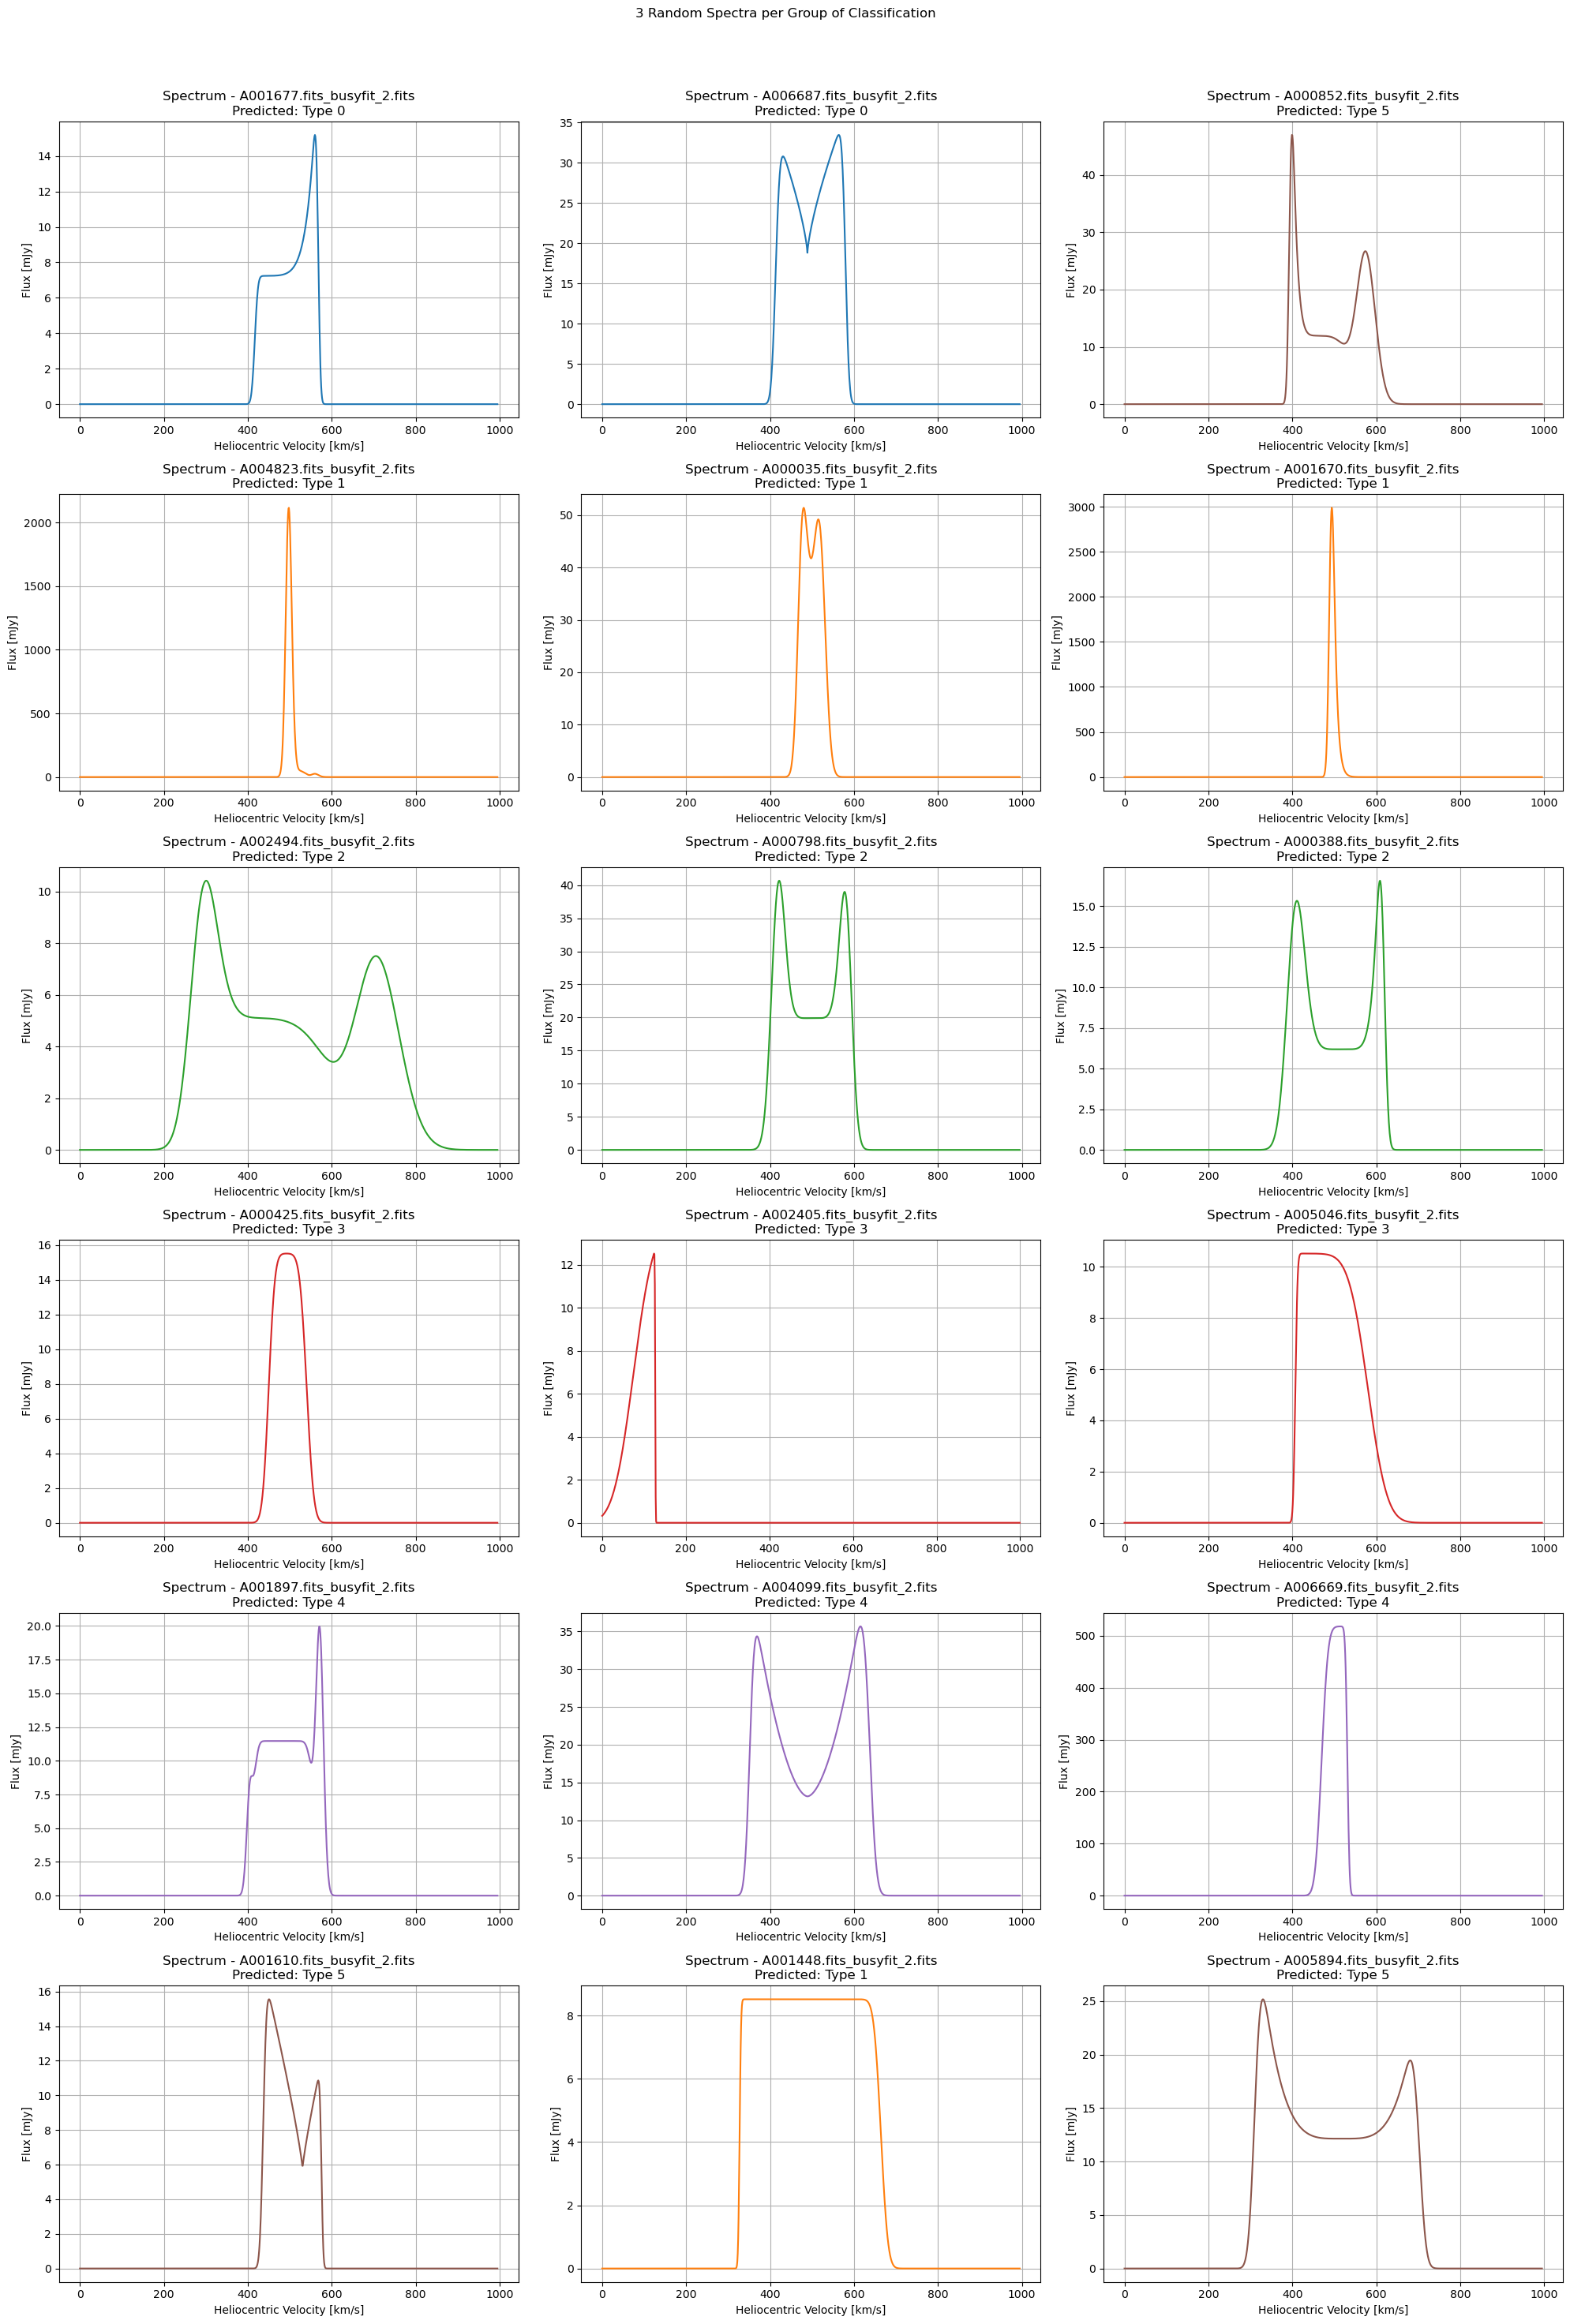

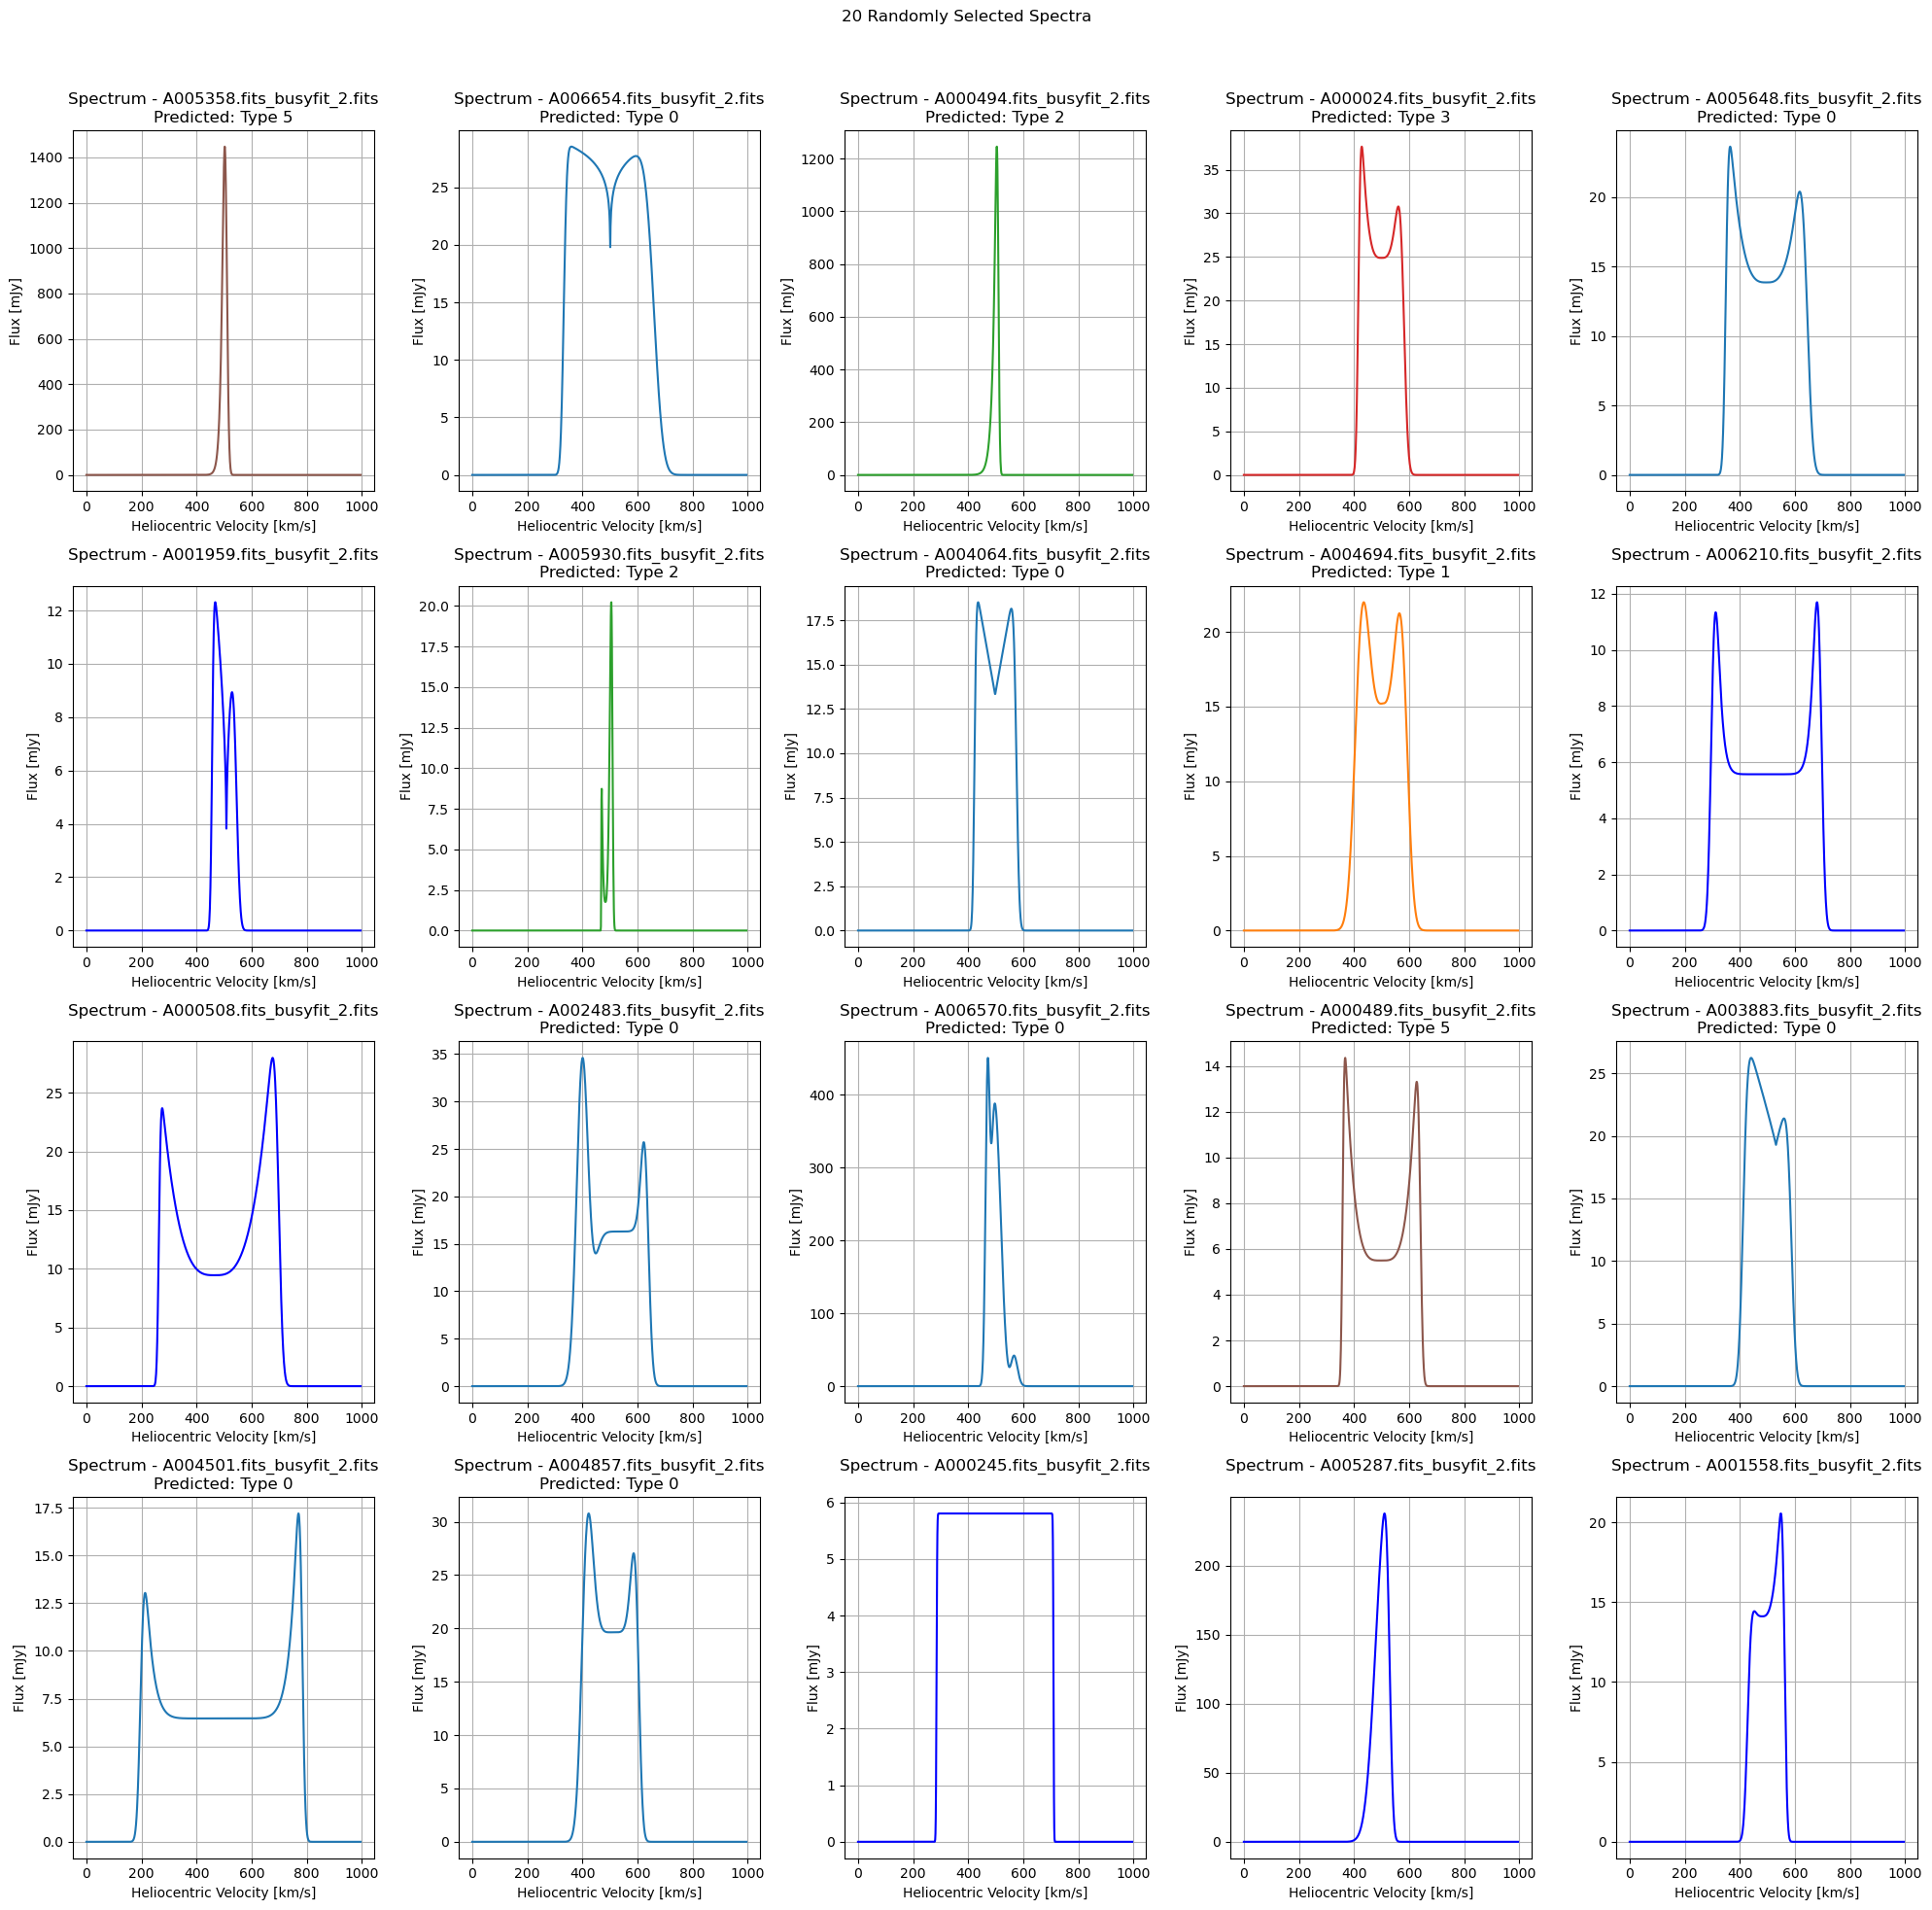

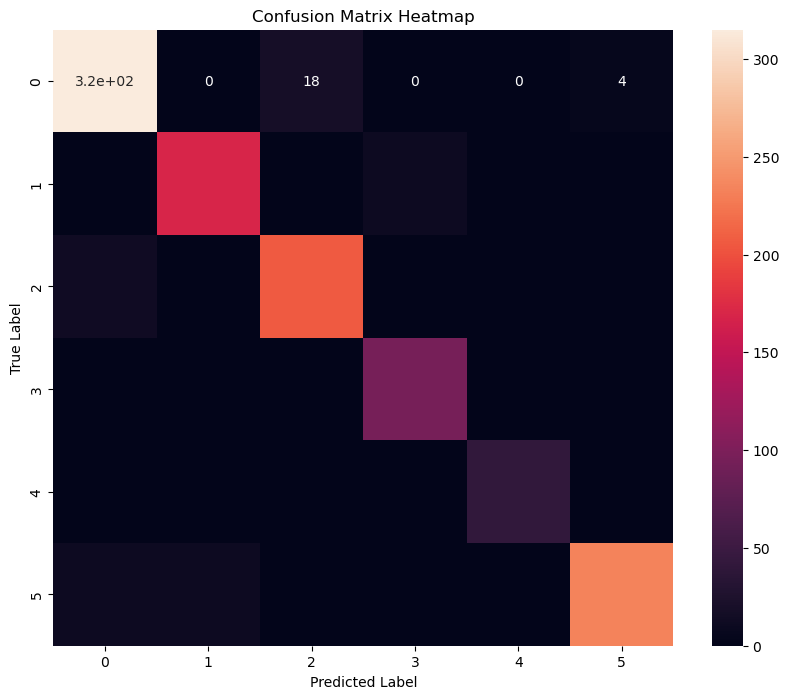

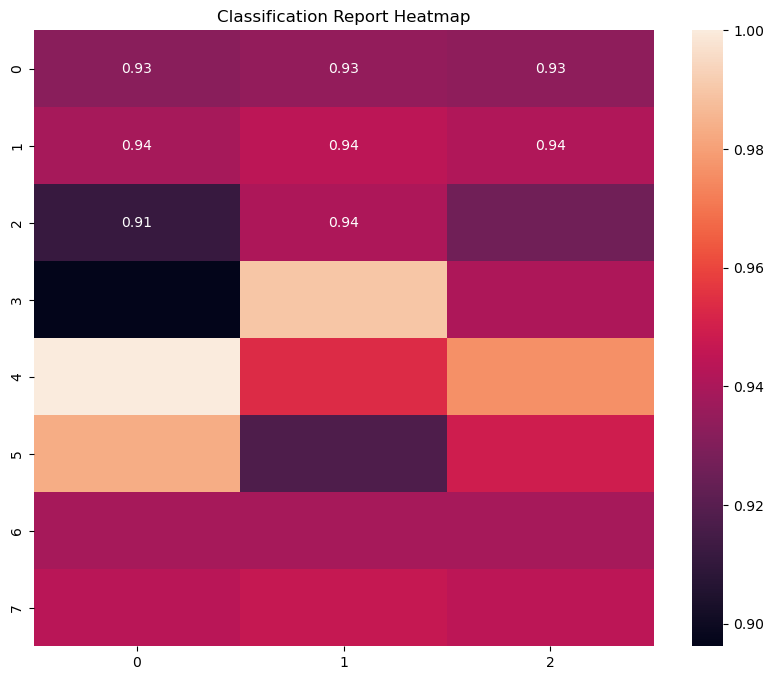

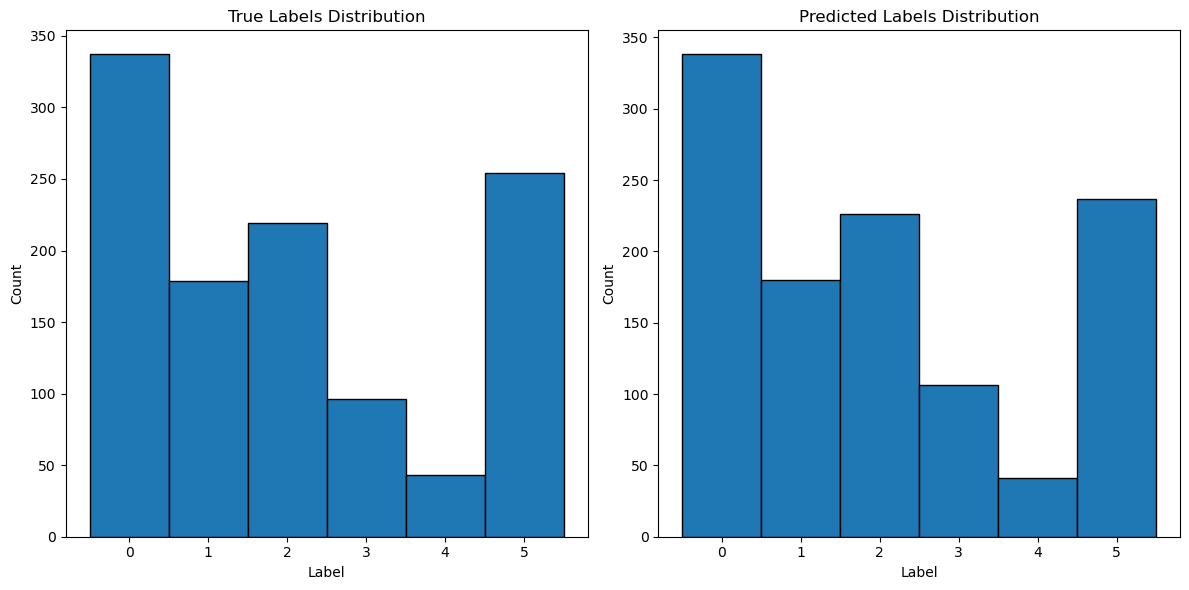

In [29]:
import numpy as np
import pandas as pd
from astropy.io import fits
from tslearn.preprocessing import TimeSeriesScalerMinMax
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, AffinityPropagation, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import random
from matplotlib.backends.backend_pdf import PdfPages

# Training variables
clustering_method = "spectral_clustering"  # Specify clustering method: "k_means", "spectral_clustering", etc.
type_of_classification = "2"   # 1, 2, 3 o double_lorentzian
number_max_fits = 2000
percentage_training = 0.25
ngroups = 6

# Change to the FITS data directory
fits_data_directory = 'D:/1. JAE Intro ICU/sp_im_busyfit/'
os.chdir(fits_data_directory)
print("Current Directory:", os.getcwd())

# Function to load data from FITS files
def load_fits_data(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[0].data[0]  # Get data from the first HDU
    return data

# Pre-filter based on 'AGC' column in the .xlsx file
alfalfa_df = pd.read_excel("filtered_data_alfalfa_1.xlsx")
agc_ids = alfalfa_df['AGC'].astype(str).tolist()
formatted_agc_ids = [f"A{agc_id.zfill(6)}" for agc_id in agc_ids]

print(f"Total AGC IDs to filter by: {len(formatted_agc_ids)}")
print("First 20 AGC IDs to filter by:")
print(formatted_agc_ids[:20])

# List and filter FITS files based on AGC IDs
file_paths_total = glob.glob(f'*_{type_of_classification}.fits')
print(f"Total FITS files found before filtering: {len(file_paths_total)}")

filtered_file_paths = [fp for fp in file_paths_total if any(agc_id in fp for agc_id in formatted_agc_ids)]
print(f"Total FITS files after filtering: {len(filtered_file_paths)}")

# Limit the number of files to process (if needed)
filtered_file_paths = filtered_file_paths[:number_max_fits]
print(f"Total FITS files after limiting to {number_max_fits}: {len(filtered_file_paths)}")

# Verify some of the filtered FITS files
for fp in filtered_file_paths[:10]:
    print(fp)

# Randomly shuffle and split the filtered FITS files into training and classification sets
random.shuffle(filtered_file_paths)
training_size = round(len(filtered_file_paths) * percentage_training)
file_paths_for_groups = filtered_file_paths[:training_size]
file_paths = filtered_file_paths[training_size:]

print("Selected method for Classification:", clustering_method)
print("Total number of samples:", len(filtered_file_paths))
print(f"Number of samples for group generation ({percentage_training}):", len(file_paths_for_groups))
print(f"Number of samples for classification ({1 - percentage_training}):", len(file_paths))

# Number of files per group (1/4 of FITS)
lgroups = round(len(file_paths) * percentage_training / ngroups)

# Ensure there are enough files for the defined groups
assert ngroups * lgroups <= len(file_paths), "Not enough files for the defined groups"

#-------- 2. Data Preprocessing ----------
def preprocess_data(file_paths):
    X_all = []
    max_length = 0
    for file in file_paths:
        data = load_fits_data(file)
        if data is not None and len(data) > 0:
            X_all.append(data)
            if len(data) > max_length:
                max_length = len(data)
    # Pad or truncate sequences
    X_all = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_all]
    return X_all, max_length

X_all, max_length = preprocess_data(file_paths)

# Normalization
scaler = TimeSeriesScalerMinMax()
X_all_scaled = scaler.fit_transform(np.array(X_all, dtype=np.float64))

# Ensure X_all_scaled is two-dimensional
X_all_scaled = X_all_scaled.reshape(X_all_scaled.shape[0], -1)

# Apply selected clustering method
if clustering_method == "k_means":
    clustering_model = KMeans(n_clusters=ngroups, random_state=0)
elif clustering_method == "spectral_clustering":
    try:
        clustering_model = SpectralClustering(n_clusters=ngroups, random_state=0, affinity='nearest_neighbors', n_neighbors=10)
    except ValueError as e:
        print(f"Error applying SpectralClustering: {e}")
        clustering_model = None
elif clustering_method == "DBSCAN":
    clustering_model = DBSCAN(eps=0.5, min_samples=5)
elif clustering_method == "AgglomerativeClustering":
    clustering_model = AgglomerativeClustering(n_clusters=ngroups)
elif clustering_method == "MeanShift":
    clustering_model = MeanShift()
elif clustering_method == "AffinityPropagation":
    clustering_model = AffinityPropagation()
elif clustering_method == "GaussianMixture":
    clustering_model = GaussianMixture(n_components=ngroups)
else:
    raise ValueError("Unsupported clustering method specified.")

if clustering_method in ["MeanShift", "AffinityPropagation", "GaussianMixture"]:
    clustering_model.fit(X_all_scaled)
    y_all = clustering_model.predict(X_all_scaled)
else:
    y_all = clustering_model.fit_predict(X_all_scaled)

if len(set(y_all)) < ngroups:
    raise ValueError("El método de clustering no generó suficientes grupos.")

X_train = []
y_train = []
X_test = []
y_test = []

for group in range(ngroups):
    indices = np.where(y_all == group)[0]
    if len(indices) > 0:
        group_size = len(indices)
        train_size = int(group_size * percentage_training)
        test_size = group_size - train_size
        train_indices = indices[:train_size]
        test_indices = indices[train_size:]
        
        X_train.extend([X_all[idx] for idx in train_indices])
        y_train.extend([group] * len(train_indices))
        
        X_test.extend([X_all[idx] for idx in test_indices])
        y_test.extend([group] * len(test_indices))
    else:
        print(f"Grupo {group} está vacío y no se incluirá en el entrenamiento.")

X_train = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_train]
X_test = [seq[:max_length] if len(seq) > max_length else np.pad(seq, (0, max_length - len(seq))) for seq in X_test]

if not X_train or not y_train:
    raise ValueError("X_train or y_train are empty. Check input data.")

X_train = np.array(X_train, dtype=np.float64).reshape(-1, max_length, 1)
X_test = np.array(X_test, dtype=np.float64).reshape(-1, max_length, 1)

y_train = np.array(y_train)
y_test = np.array(y_test)

y_train_categorical = to_categorical(y_train, num_classes=ngroups)

# Define CNN model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(max_length, 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(ngroups, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_categorical, epochs=20, batch_size=32)

# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Generating the classification results
file_to_classification = {file: prediction for file, prediction in zip(filtered_file_paths, y_pred_classes)}

# Initialize the 'Classification' column with None
alfalfa_df['Classification'] = None

# Assign the classifications to the corresponding AGC IDs in the DataFrame
for idx, row in alfalfa_df.iterrows():
    agc_id = str(row['AGC'])
    matched_file = next((file for file in filtered_file_paths if agc_id in file), None)
    if matched_file and matched_file in file_to_classification:
        alfalfa_df.at[idx, 'Classification'] = file_to_classification[matched_file]

# Check for missing classifications
missing_classifications = alfalfa_df[alfalfa_df['Classification'].isna()]
if not missing_classifications.empty:
    print("Se encontraron archivos sin clasificación:")
    print(missing_classifications)

# Save the updated DataFrame to an Excel file
result_file_path = "filtered_data_alfalfa_classification_results_CNN_spectral_clustering_2.xlsx"
alfalfa_df.to_excel(result_file_path, index=False)
print(f"Resultados guardados en {result_file_path}")

# Generate classification report and confusion matrix
classification_report_dict = classification_report(y_test, y_pred_classes, output_dict=True)
confusion_matrix_result = confusion_matrix(y_test, y_pred_classes)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

print("Confusion Matrix:")
print(confusion_matrix_result)

# Save classification report and confusion matrix to .xlsx file
classification_report_df = pd.DataFrame(classification_report_dict).transpose()
confusion_matrix_df = pd.DataFrame(confusion_matrix_result, index=range(ngroups), columns=range(ngroups))

with pd.ExcelWriter("classification_report_and_confusion_matrix.xlsx") as writer:
    classification_report_df.to_excel(writer, sheet_name="Classification Report")
    confusion_matrix_df.to_excel(writer, sheet_name="Confusion Matrix")

# Visualize FITS files and save to .pdf
def plot_fits_spectra_grouped(file_paths, labels, predictions, ngroups, num_per_group=3, num_columns=3):
    fig, axes = plt.subplots(ngroups, num_per_group, figsize=(20, 5 * ngroups))
    colors = plt.get_cmap('tab10').colors
    fig.suptitle("3 Random Spectra per Group of Classification")

    for group in range(ngroups):
        group_indices = [i for i, label in enumerate(labels) if label == group]
        random_indices = random.sample(group_indices, min(len(group_indices), num_per_group))
        
        for j, idx in enumerate(random_indices):
            file_path = file_paths[idx]
            with fits.open(file_path) as hdul:
                data_spectrum = hdul[0].data
                data_spectrum = np.squeeze(data_spectrum)
            velocity = np.arange(len(data_spectrum))
            ax = axes[group, j]
            color = colors[predictions[idx] % 10] if predictions is not None else 'b'
            label = f'Predicted: Type {predictions[idx]}' if predictions is not None else f'True: Type {labels[idx]}'
            ax.plot(velocity, data_spectrum, color=color)
            ax.set_title(f'Spectrum - {os.path.basename(file_path)}\n{label}')
            ax.set_xlabel('Heliocentric Velocity [km/s]')
            ax.set_ylabel('Flux [mJy]')
            ax.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

def plot_fits_spectra_random(file_paths, title, labels=None, predictions=None, num_columns=5, num_plots=20):
    num_rows = (num_plots + num_columns - 1) // num_columns
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))
    fig.suptitle(title)
    random_indices = np.random.choice(len(file_paths), num_plots, replace=False)
    colors = plt.get_cmap('tab10').colors

    for i, idx in enumerate(random_indices):
        file_path = file_paths[idx]
        with fits.open(file_path) as hdul:
            data_spectrum = hdul[0].data
            data_spectrum = np.squeeze(data_spectrum)
        velocity = np.arange(len(data_spectrum))
        ax = axes[i // num_columns, i % num_columns]
        if predictions is not None and idx < len(predictions):
            color = colors[predictions[idx] % 10]
            label = f'Predicted: Type {predictions[idx]}'
        elif labels is not None and idx < len(labels):
            color = colors[labels[idx] % 10]
            label = f'True: Type {labels[idx]}'
        else:
            color = 'b'
            label = ''
        ax.plot(velocity, data_spectrum, color=color)
        ax.set_title(f'Spectrum - {os.path.basename(file_path)}\n{label}')
        ax.set_xlabel('Heliocentric Velocity [km/s]')
        ax.set_ylabel('Flux [mJy]')
        ax.grid(True)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# Save plots to PDF
with PdfPages("filtered_data_alfalfa_classification_results_CNN_spectral_clustering_2.pdf") as pdf:
    fig1 = plot_fits_spectra_grouped(file_paths, y_test, y_pred_classes, ngroups, num_per_group=3)
    pdf.savefig(fig1)
    plt.close(fig1)
    
    fig2 = plot_fits_spectra_random(file_paths, "20 Randomly Selected Spectra", labels=y_test, predictions=y_pred_classes, num_columns=5, num_plots=20)
    pdf.savefig(fig2)
    plt.close(fig2)

    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix_result, annot=True)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.close()

    # Plot the classification report as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(classification_report_df.iloc[:-1, :-1], annot=True)
    plt.title('Classification Report Heatmap')
    pdf.savefig()  # Save classification report heatmap
    plt.close()

    # Generate histograms of true vs predicted labels
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(y_test, bins=np.arange(ngroups + 1) - 0.5, edgecolor='black')
    plt.xticks(range(ngroups))
    plt.title('True Labels Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    plt.hist(y_pred_classes, bins=np.arange(ngroups + 1) - 0.5, edgecolor='black')
    plt.xticks(range(ngroups))
    plt.title('Predicted Labels Distribution')
    plt.xlabel('Label')
    plt.ylabel('Count')
    
    plt.tight_layout()
    pdf.savefig()  # Save histograms
    plt.close()

print("Plots saved to PDF.")

# Visualize plots interactively
plot_fits_spectra_grouped(file_paths, y_test, y_pred_classes, ngroups, num_per_group=3)
plot_fits_spectra_random(file_paths, "20 Randomly Selected Spectra", labels=y_test, predictions=y_pred_classes, num_columns=5, num_plots=20)

plt.figure(figsize=(10, 8))
sns.heatmap(np.array(confusion_matrix_result), annot=True)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



# Plot the classification report as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(np.array(classification_report_df.iloc[:-1, :-1]), annot=True)
plt.title('Classification Report Heatmap')
plt.show()

# Generate histograms of true vs predicted labels
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(y_test, bins=np.arange(ngroups + 1) - 0.5, edgecolor='black')
plt.xticks(range(ngroups))
plt.title('True Labels Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(y_pred_classes, bins=np.arange(ngroups + 1) - 0.5, edgecolor='black')
plt.xticks(range(ngroups))
plt.title('Predicted Labels Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
